# Imports #

In [1]:
%%time

# Import libraries and show its versions
import os
import sys
import pathlib
from pathlib import Path
import glob
from glob import glob
import collections
from collections import OrderedDict
import datetime
from datetime import date
import warnings
import matplotlib.pyplot as plt

try:
    import numpy as np; print('NumPy version: ', np.__version__)
    from numpy import array, asarray, delete, append
except:
    !{sys.executable} -m pip install numpy==1.19.5
    import numpy as np; print('NumPy version: ', np.__version__)
    from numpy import array, asarray, delete, append

try:
    import pandas as pd; print('Pandas version: ', pd.__version__)
    from pandas import read_csv, DataFrame, concat, merge
except:
    !{sys.executable} -m pip install pandas
    import pandas as pd; print('Pandas version: ', pd.__version__)
    from pandas import read_csv, DataFrame, concat, merge

try:
    import statsmodels as stmdls; print('StatsModels version: ', stmdls.__version__)
    from statsmodels.tsa.seasonal import seasonal_decompose
except:
    !{sys.executable} -m pip install statsmodels
    import statsmodels as stmdls; print('StatsModels version: ', stmdls.__version__)
    from statsmodels.tsa.seasonal import seasonal_decompose

try:
    import matplotlib as mpl; print('MatPlotLib version: ', mpl.__version__)
    from matplotlib import pyplot as plt
except:
    !{sys.executable} -m pip install matplotlib
    import matplotlib as mpl; print('MatPlotLib version: ', mpl.__version__)
    from matplotlib import pyplot as plt

# Configurations
np.set_printoptions(linewidth=1000)
pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (20,3)
#warnings.filterwarnings('ignore')

print()

NumPy version:  1.23.5
Pandas version:  2.1.3
StatsModels version:  0.14.0
MatPlotLib version:  3.8.2

CPU times: user 2.41 s, sys: 5.84 s, total: 8.25 s
Wall time: 985 ms


# Define parameters #

In [2]:
%%time

# ---FUNCTIONS---
# Date parser
def custom_date_parser(date):
    try:
        return pd.to_datetime(date, format='%Y-%m-%d %H:%M:%S')
    except ValueError:
        return pd.to_datetime(date, format='%d/%m/%Y %H:%M')

# ---PARAMETERS---
# Global variables
multivariate_variables = {
    'Bilbao': [
        'Benceno',
        'CO',
        'CO 8h',
        'Etilbenceno',
        'NO',
        'NO2',
        'NOX',
        'O3',
        'O3 8h',
        'Ortoxileno',
        'PM10',
        'PM2.5',
        'SO2',
        'Tolueno',
        'DirecWind',
        'Humid',
        'Precip',
        'Temp',
        'SpeedWind',
        'Car',
        'Motorcycle',
        'Bus',
        'Truck'
    ],
    'Madrid': [
        'CO',
        'O3',
        'PM10',
        'PM2.5',
        'SO2',
        'SpeedWind',
        'DirecWind',
        'Temp',
        'Humid',
        'Precip',
        'Car',
        'Motorcycle',
        'Bus',
        'Truck'
    ]
}
look_back = {
    'Bilbao': 24 * 1,
    'Madrid': 24 * 1,
}
years_of_study = 1

# Dataset variables
datasets = {}
synth_datasets = {}

CPU times: user 5 µs, sys: 9 µs, total: 14 µs
Wall time: 21.5 µs


# Read datasets #

In [3]:
%%time

# Iterate over all possible train datasets
for file in glob('./datasets/*.csv'):

    # Print a header
    print('-' * 37, Path(file).stem.upper(), '-' * 37)
    
    # Read a dataset
    datasets[Path(file).stem] = read_csv(file, parse_dates={'Fecha_Hora': ['Fecha', 'Hora']}, date_parser=custom_date_parser, index_col='Fecha_Hora')
    
    # Select variables
    datasets[Path(file).stem] = datasets[Path(file).stem][multivariate_variables[Path(file).stem]]

    # Iterpolate datasets
    datasets[Path(file).stem] = datasets[Path(file).stem].interpolate('linear')
    
    # Auxiliar variables
    #freq = int(Path(file).stem.split('_')[0].split('-')[-1])
    #reg_per_hour = int(60/freq)
    reg_per_hour = 1
    
    # Select years of study
    #datasets[Path(file).stem] = datasets[Path(file).stem].iloc[-years_of_study*365*24*reg_per_hour:]
    
    """
    # Translate column names to english
    datasets[Path(file).stem] = datasets[Path(file).stem].rename(columns={
        'CajaMedida1.TBS': 'IndoorTemperature',
        'CajaMedida1.TBH': 'WetBulbTemperature',
        'CajaMedida1.HR': 'RelativeHumidity',
        'CajaMedida1.DH': 'WaterDeficit',
        'TemperaturaExterior': 'ExternalTemperature',
        'HumedadExterior': 'ExternalHumidity',
        'DireccionViento': 'WindDirecction',
        'VelocidadViento': 'WindSpeed',
        'Radiacion': 'Radiation',
        'LecturaCO2': 'CO2',
    })
    """
    
    # Print dataset info
    print(datasets[Path(file).stem].info())
    
    # Print a header
    print('-' * 37, Path(file).stem.upper(), 'SYNTH', '-' * 37)
    
    # Read a dataset
    datasets[f'{Path(file).stem} Synth'] = read_csv(f'{Path(file).parent}/synth/{Path(file).stem}_synth.csv', parse_dates=True, index_col=[0], sep=';', decimal='.')
    
    # Select variables
    datasets[f'{Path(file).stem} Synth'] = datasets[f'{Path(file).stem} Synth'][multivariate_variables[Path(file).stem]]

    """
    # Auxiliar variables
    #freq = int(Path(file).stem.split('_')[0].split('-')[-1])
    #reg_per_hour = int(60/freq)
    reg_per_hour = 1
    
    # Select years of study
    datasets[f'{Path(file).stem} Synth'] = datasets[f'{Path(file).stem} Synth'].iloc[-years_of_study*365*24*reg_per_hour:]
    """
    
    # Print dataset info
    print(datasets[f'{Path(file).stem} Synth'].info())

# Order datasets
key_order = {k:v for v,k in enumerate([
    'Bilbao',
    'Bilbao Synth',
    'Madrid',
    'Madrid Synth',
])}
ordered_dict = OrderedDict(sorted(datasets.items(), key=lambda i:key_order.get(i[0])))
datasets = ordered_dict

print()

------------------------------------- BILBAO -------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2023-09-18 20:00:00 to 2023-10-03 09:00:00
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Benceno      350 non-null    float64
 1   CO           350 non-null    float64
 2   CO 8h        350 non-null    float64
 3   Etilbenceno  350 non-null    float64
 4   NO           350 non-null    float64
 5   NO2          350 non-null    float64
 6   NOX          350 non-null    float64
 7   O3           350 non-null    float64
 8   O3 8h        350 non-null    float64
 9   Ortoxileno   350 non-null    float64
 10  PM10         350 non-null    float64
 11  PM2.5        350 non-null    float64
 12  SO2          350 non-null    float64
 13  Tolueno      350 non-null    float64
 14  DirecWind    350 non-null    float64
 15  Humid        350 non-null    float64
 16  Precip       3

<timed exec>:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
<timed exec>:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
<timed exec>:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.


<class 'pandas.core.frame.DataFrame'>
Index: 87600 entries, 0 to 87599
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Benceno      87600 non-null  float64
 1   CO           87600 non-null  float64
 2   CO 8h        87600 non-null  float64
 3   Etilbenceno  87600 non-null  float64
 4   NO           87600 non-null  float64
 5   NO2          87600 non-null  float64
 6   NOX          87600 non-null  float64
 7   O3           87600 non-null  float64
 8   O3 8h        87600 non-null  float64
 9   Ortoxileno   87600 non-null  float64
 10  PM10         87600 non-null  float64
 11  PM2.5        87600 non-null  float64
 12  SO2          87600 non-null  float64
 13  Tolueno      87600 non-null  float64
 14  DirecWind    86091 non-null  float64
 15  Humid        87600 non-null  float64
 16  Precip       87600 non-null  float64
 17  Temp         87600 non-null  float64
 18  SpeedWind    87600 non-null  float64
 19  Car      

<timed exec>:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


# Exploratory Data Analysis #

------------------------------------- BILBAO -------------------------------------
------- Dataset description -------
       Benceno       CO   CO 8h  Etilbenceno       NO      NO2      NOX  \
count  350.000  350.000  350.00      350.000  350.000  350.000  350.000   
mean     0.135    0.332    0.33        0.199   11.049   28.326   45.088   
std      0.162    0.088    0.07        0.216   14.293   12.281   30.216   
min      0.000    0.140    0.18        0.000    0.330    2.000    2.670   
25%      0.020    0.270    0.28        0.000    3.000   19.082   23.542   
50%      0.080    0.330    0.33        0.120    5.330   27.835   38.670   
75%      0.209    0.388    0.38        0.330   11.585   36.918   55.585   
max      1.280    0.670    0.47        1.060   75.670   68.330  171.330   

            O3    O3 8h  Ortoxileno     PM10    PM2.5      SO2  Tolueno  \
count  350.000  350.000     350.000  350.000  350.000  350.000  350.000   
mean    35.063   35.254       1.046   17.321    9.763  

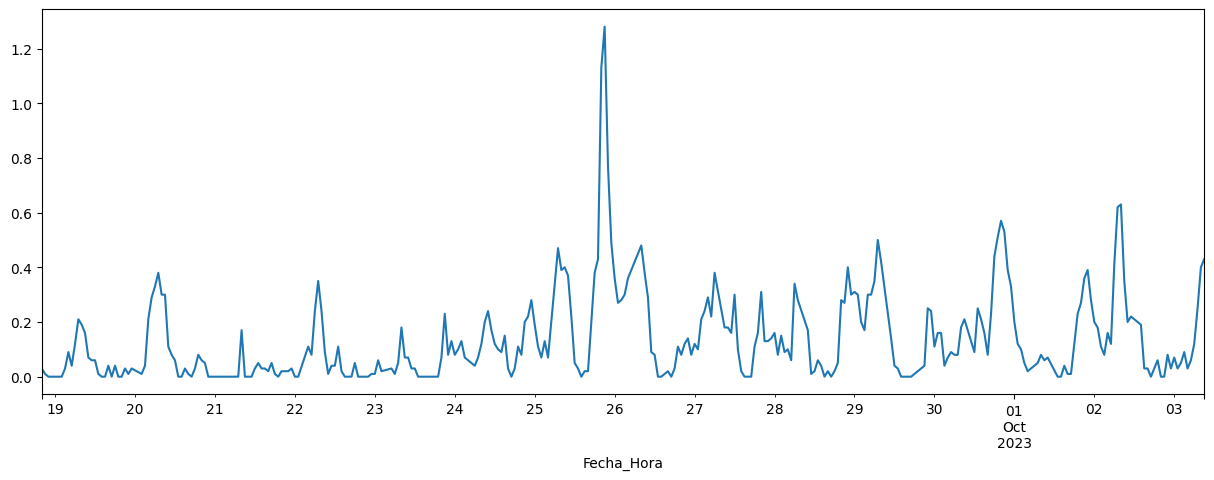


----------------- CO -----------------
------- Timeseries -------


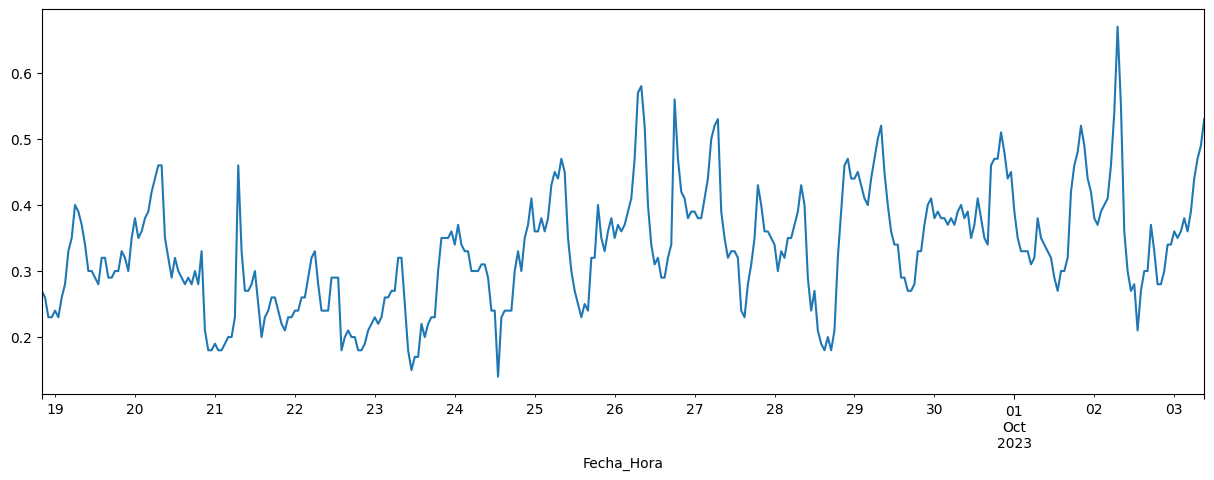


----------------- CO 8H -----------------
------- Timeseries -------


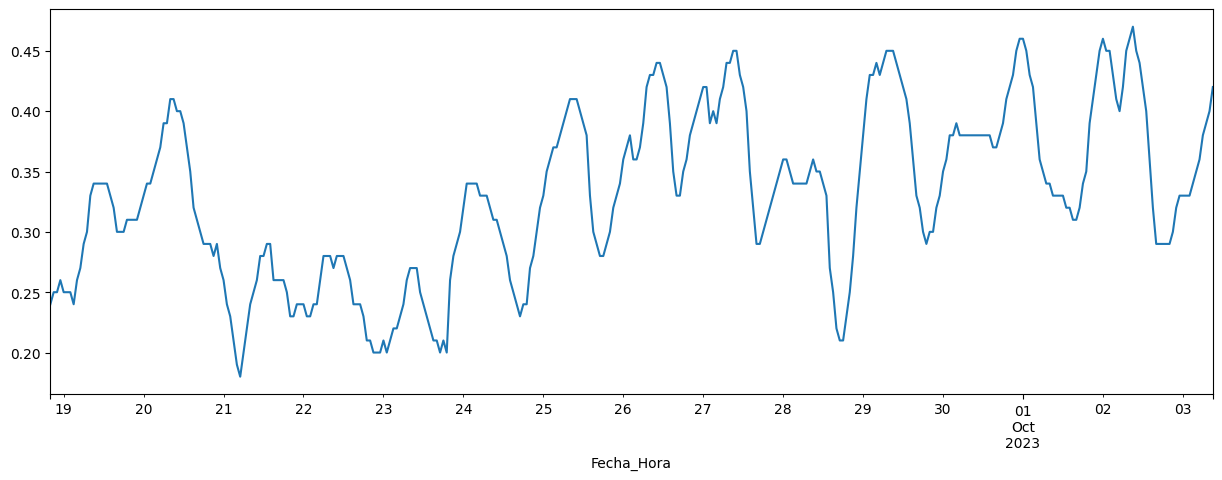


----------------- ETILBENCENO -----------------
------- Timeseries -------


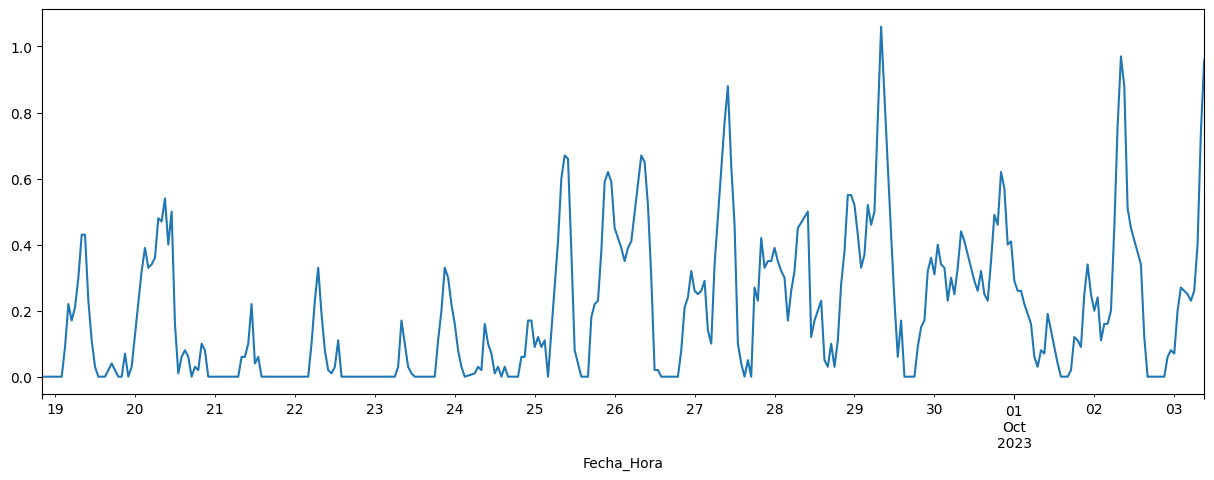


----------------- NO -----------------
------- Timeseries -------


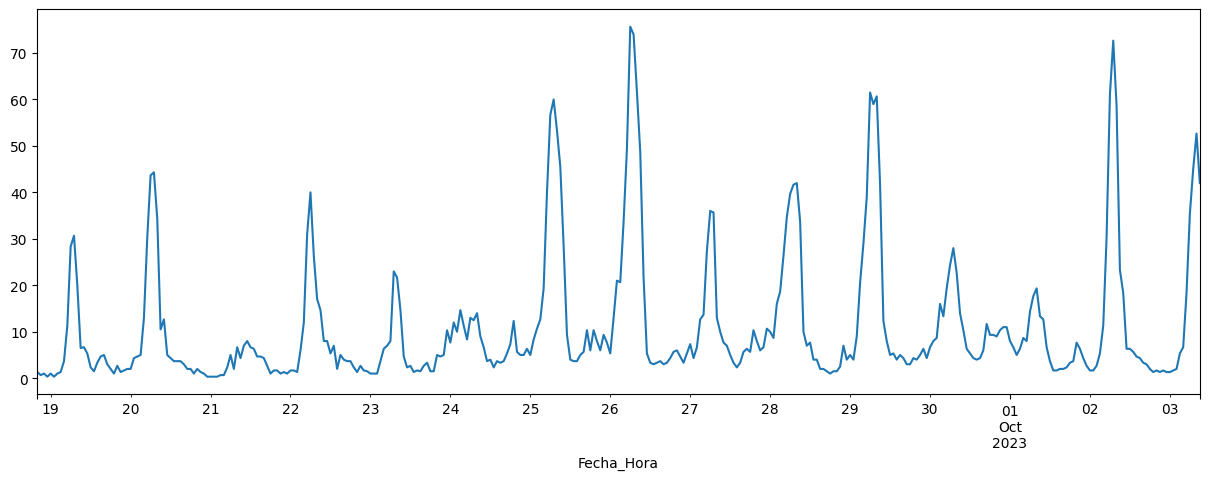


----------------- NO2 -----------------
------- Timeseries -------


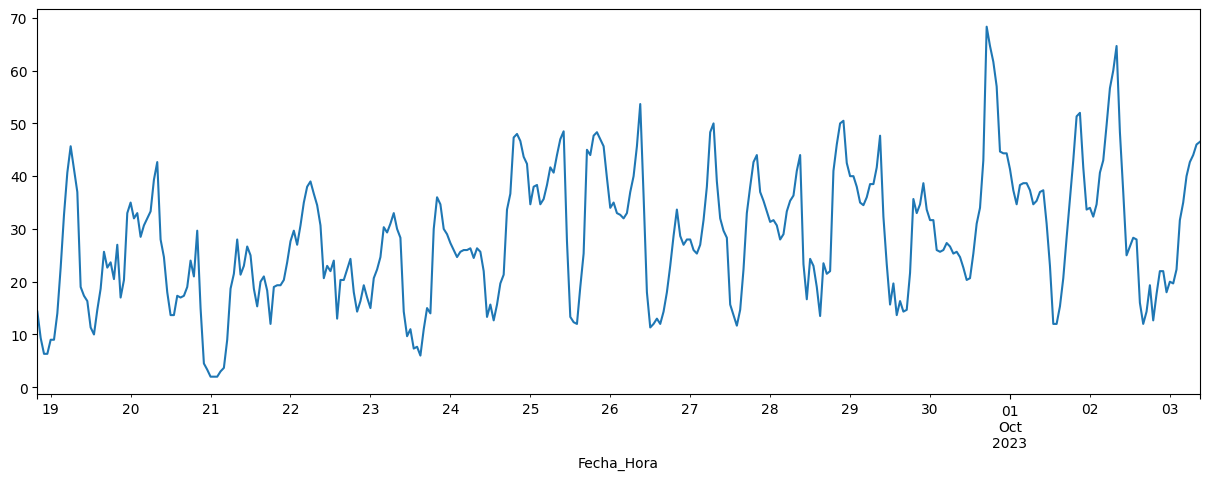


----------------- NOX -----------------
------- Timeseries -------


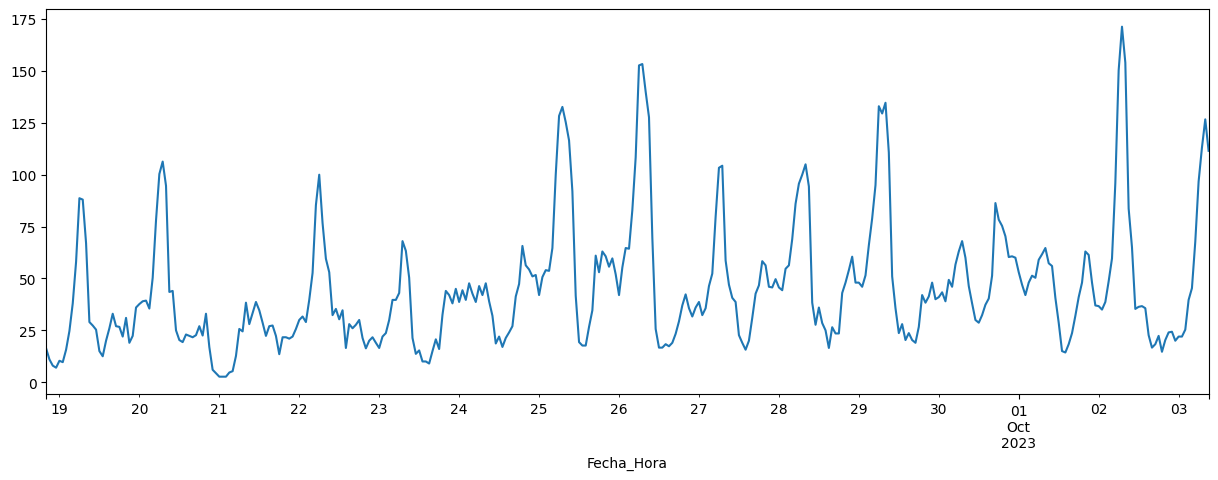


----------------- O3 -----------------
------- Timeseries -------


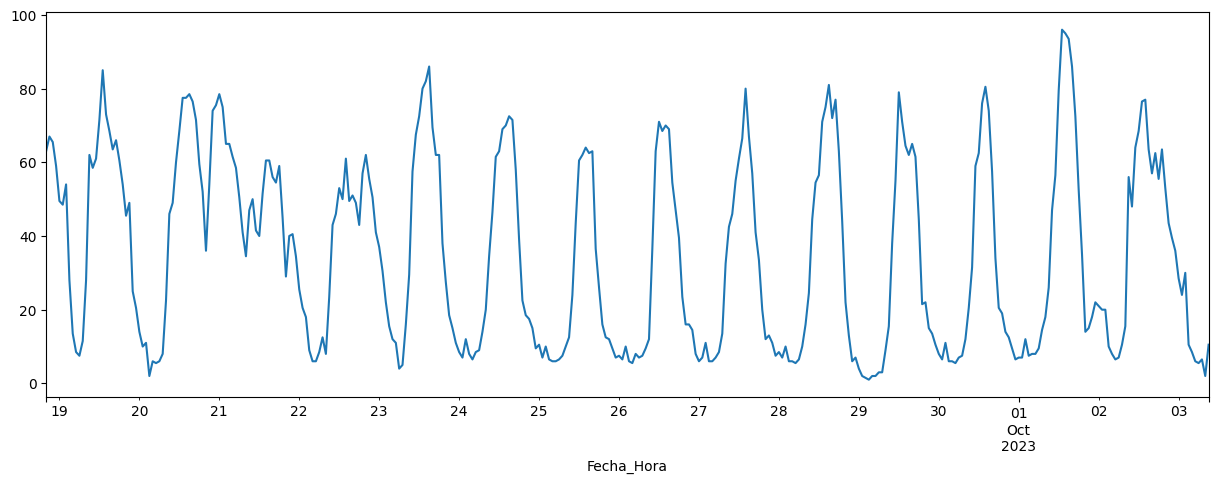


----------------- O3 8H -----------------
------- Timeseries -------


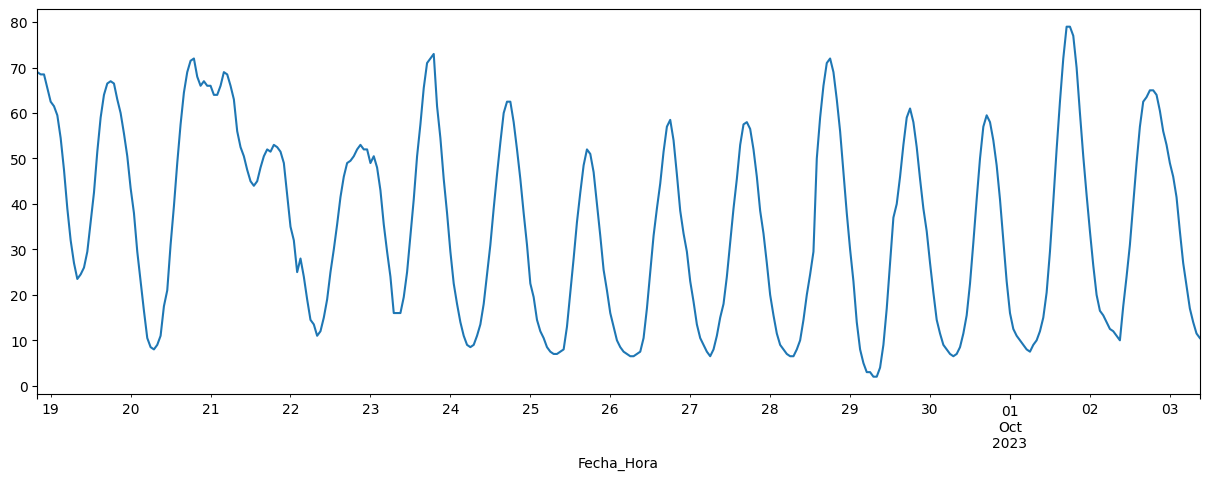


----------------- ORTOXILENO -----------------
------- Timeseries -------


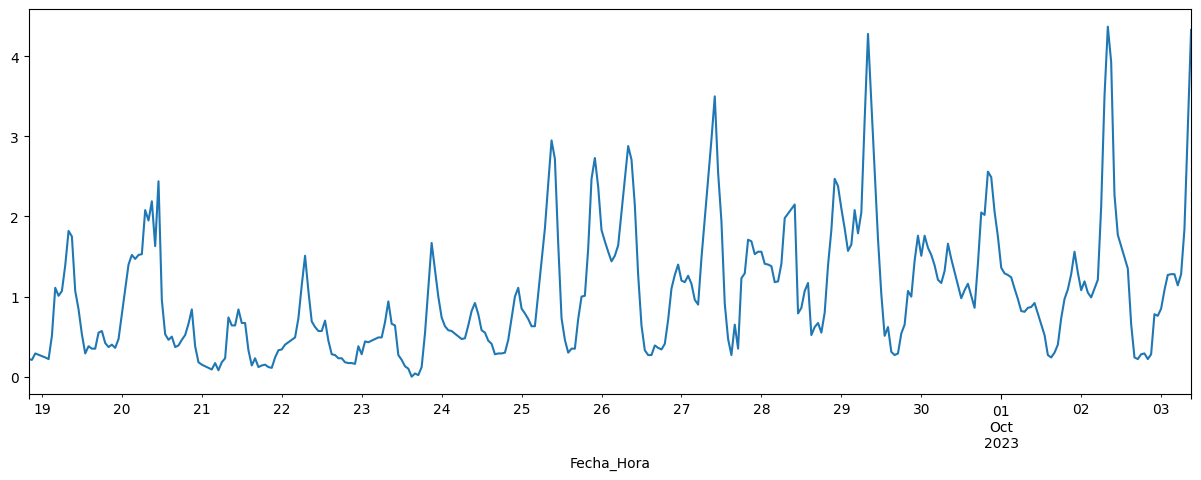


----------------- PM10 -----------------
------- Timeseries -------


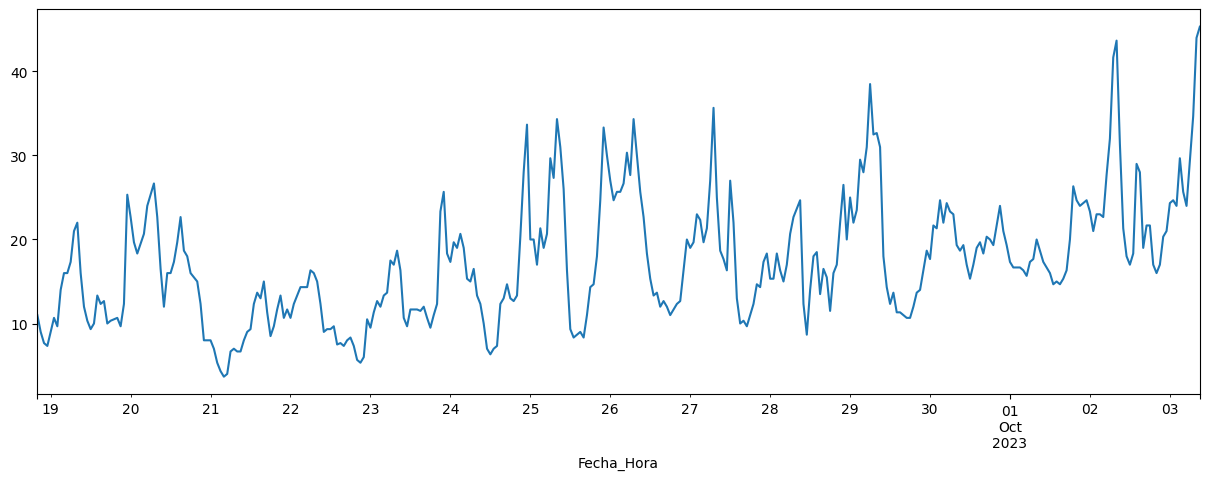


----------------- PM2.5 -----------------
------- Timeseries -------


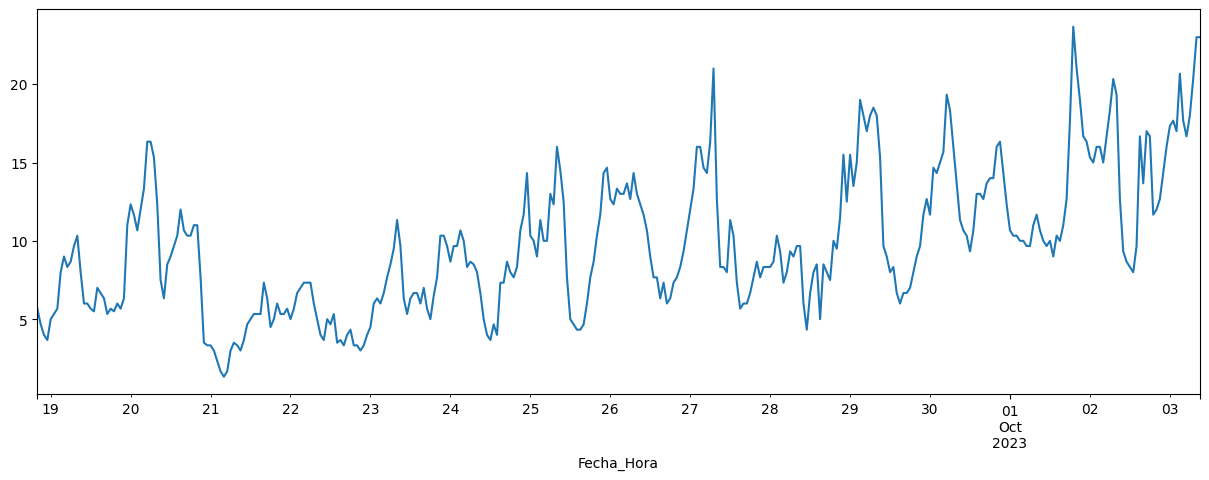


----------------- SO2 -----------------
------- Timeseries -------


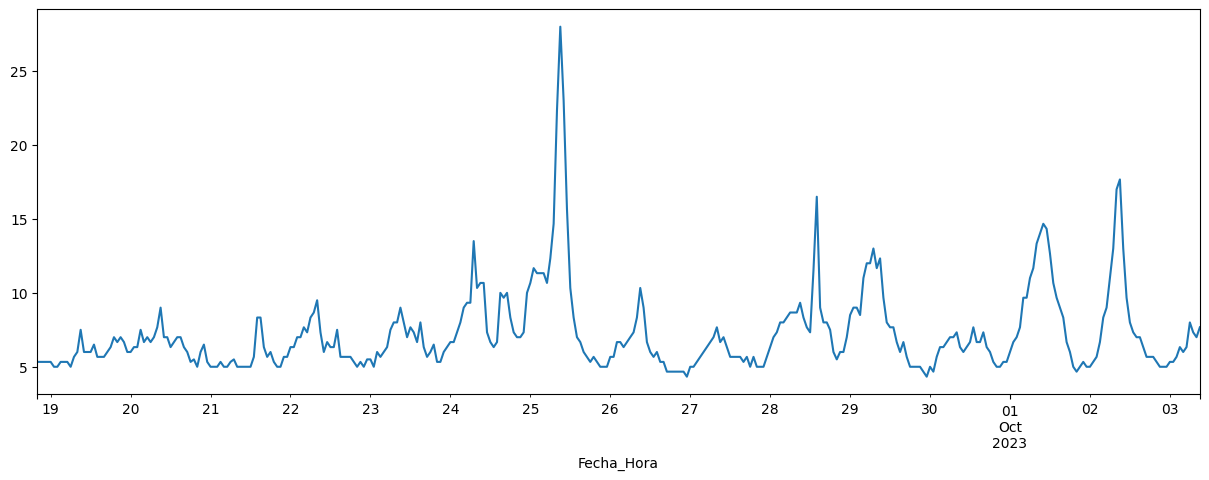


----------------- TOLUENO -----------------
------- Timeseries -------


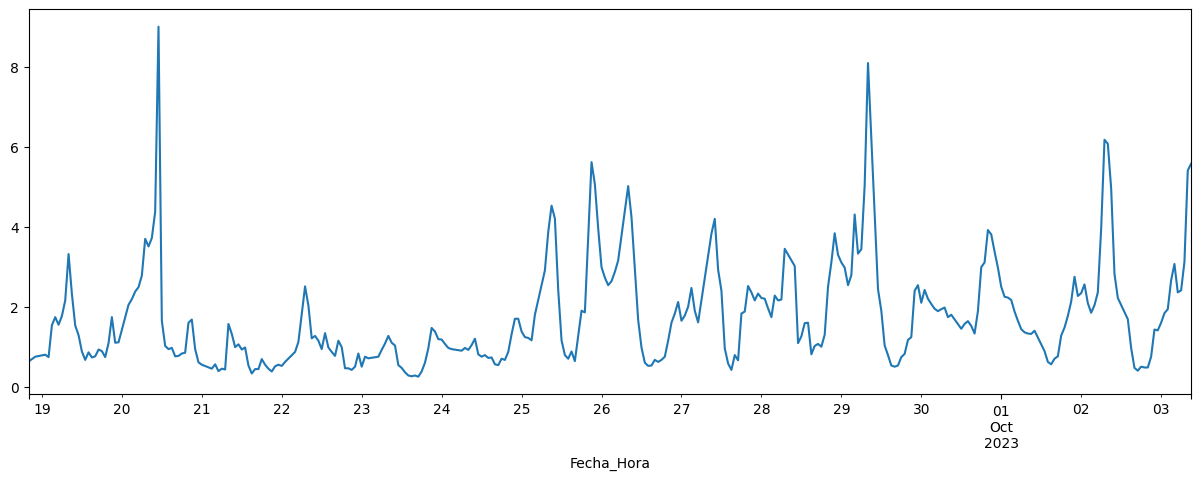


----------------- DIRECWIND -----------------
------- Timeseries -------


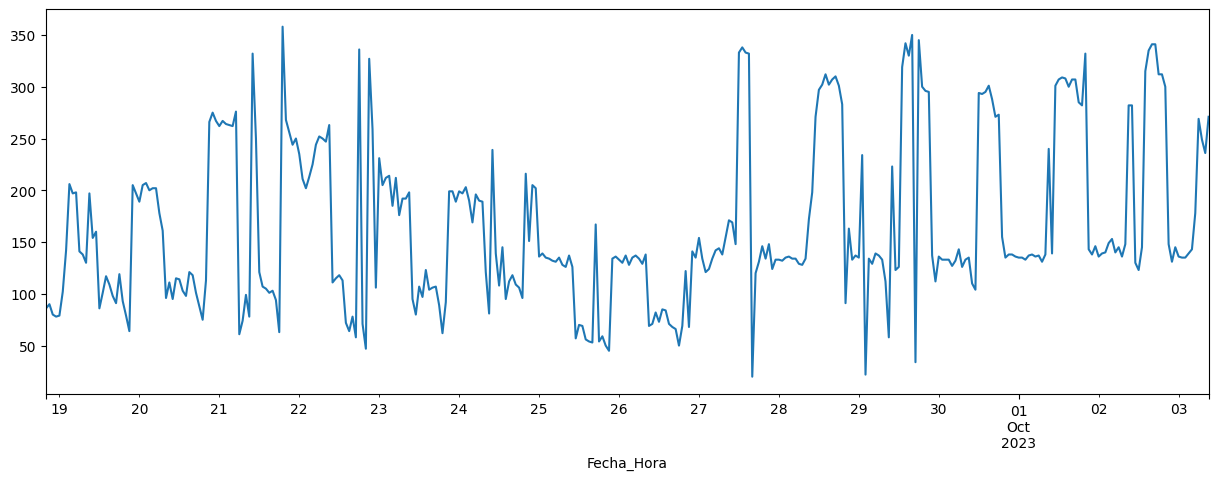


----------------- HUMID -----------------
------- Timeseries -------


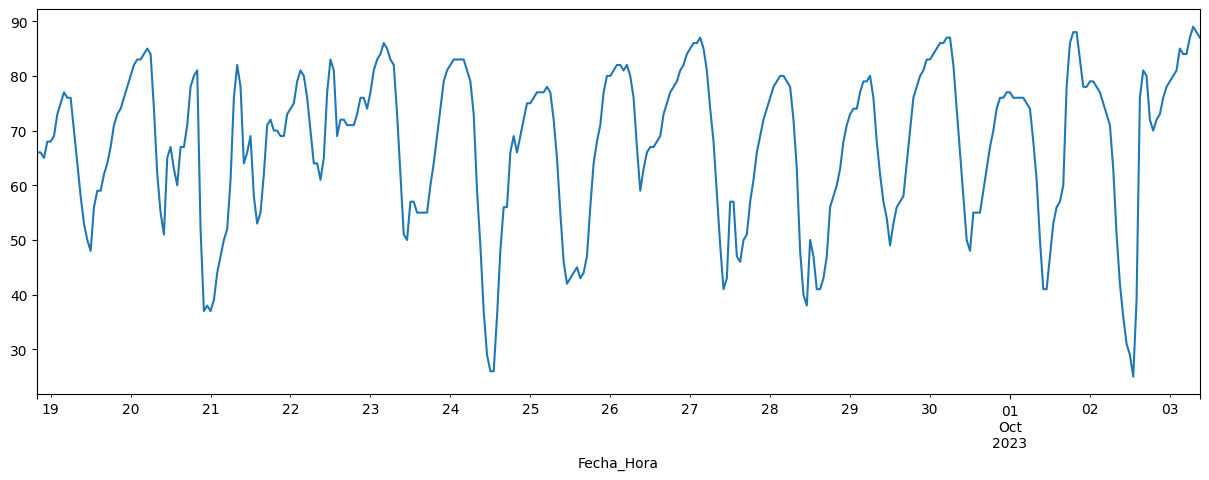


----------------- PRECIP -----------------
------- Timeseries -------


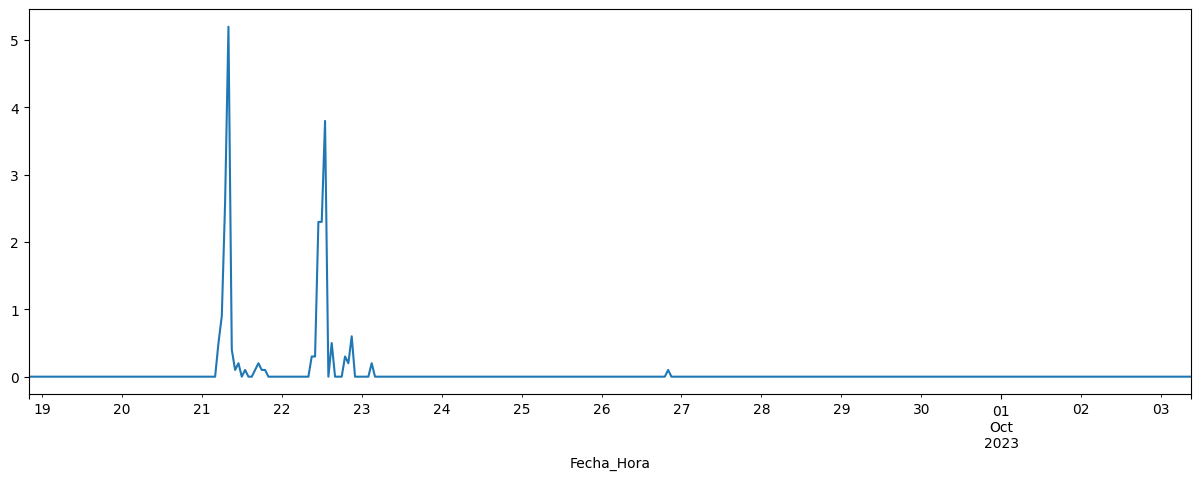


----------------- TEMP -----------------
------- Timeseries -------


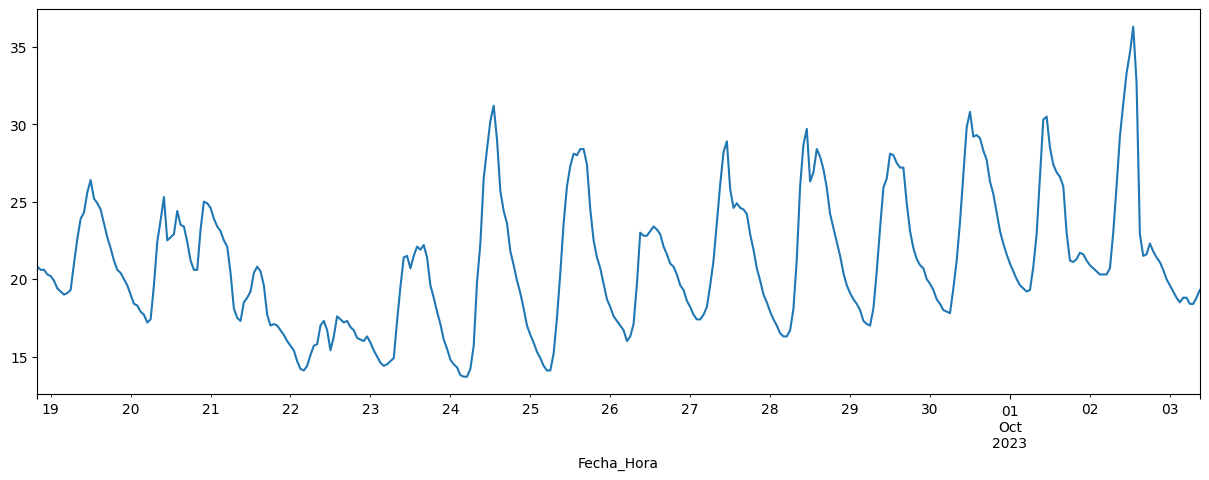


----------------- SPEEDWIND -----------------
------- Timeseries -------


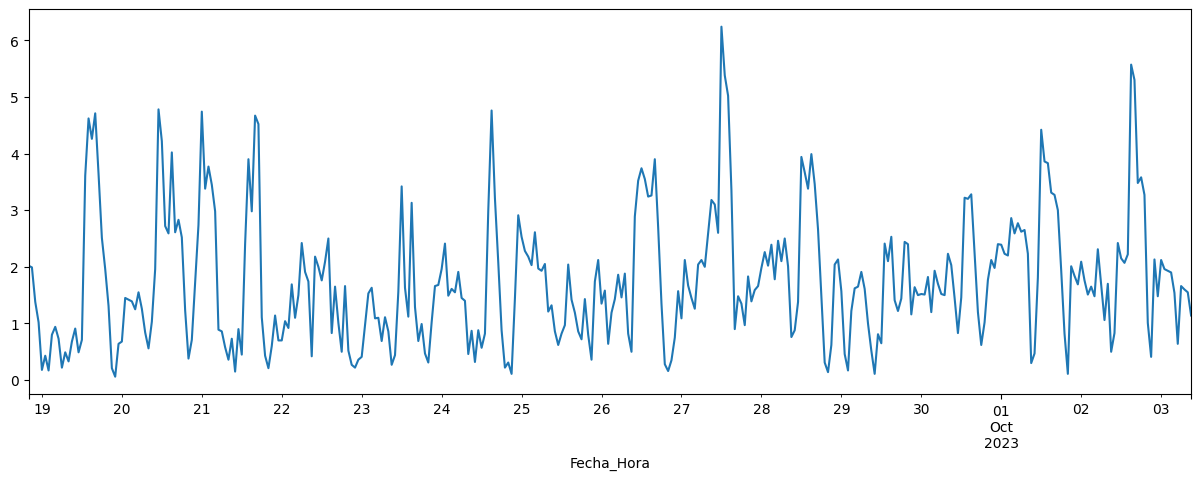


----------------- CAR -----------------
------- Timeseries -------


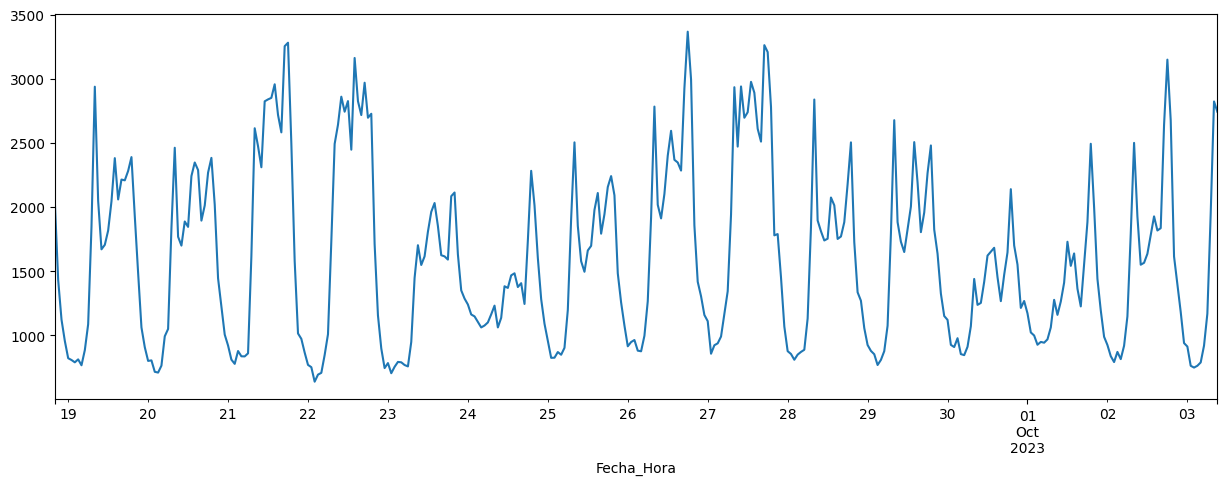


----------------- MOTORCYCLE -----------------
------- Timeseries -------


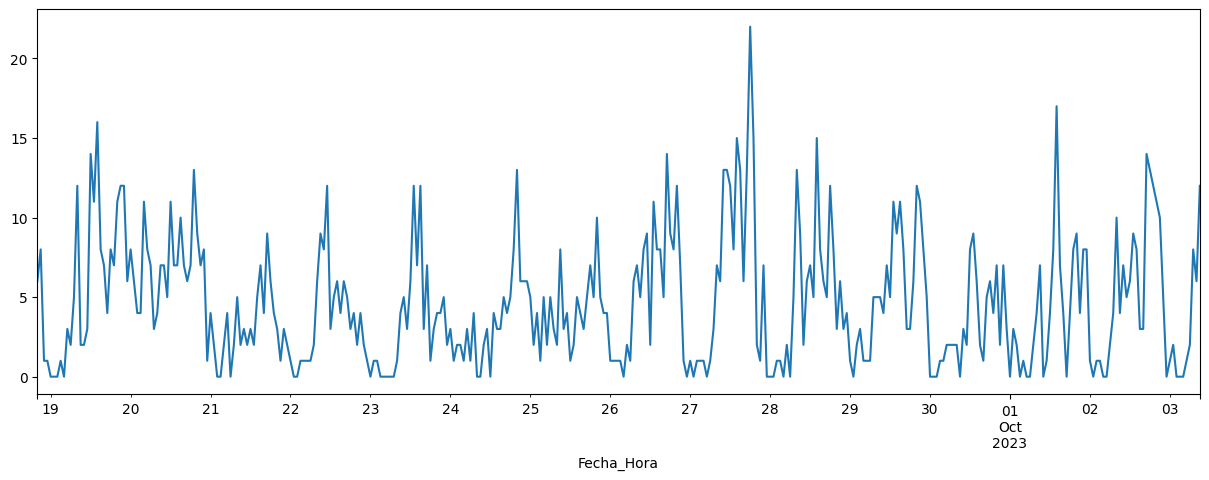


----------------- BUS -----------------
------- Timeseries -------


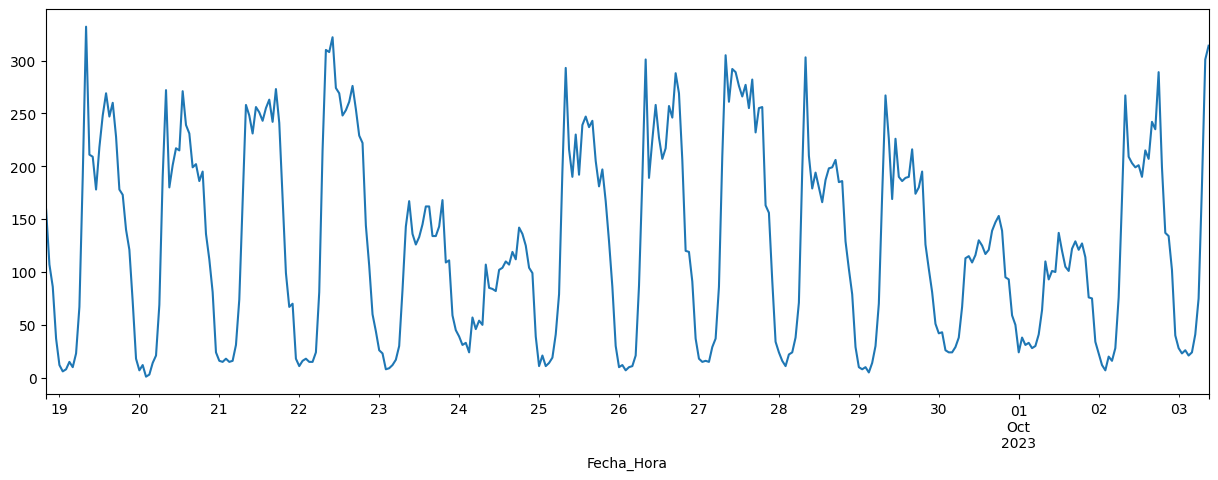


----------------- TRUCK -----------------
------- Timeseries -------


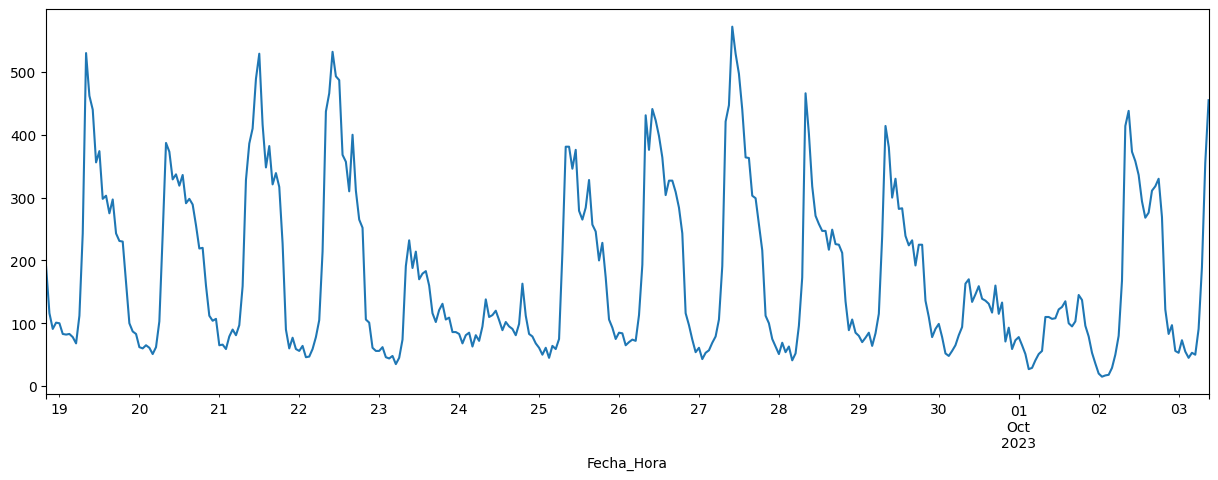


------------------------------------- BILBAO SYNTH -------------------------------------
------- Dataset description -------
         Benceno         CO      CO 8h  Etilbenceno         NO        NO2  \
count  87600.000  87600.000  87600.000    87600.000  87600.000  87600.000   
mean       0.139      0.331      0.330        0.198     10.978     28.373   
std        0.157      0.083      0.066        0.200     13.767     11.566   
min        0.000      0.148      0.183        0.000      0.353      2.778   
25%        0.027      0.271      0.280        0.033      3.191     19.288   
50%        0.088      0.325      0.328        0.135      5.396     28.085   
75%        0.202      0.382      0.380        0.310     11.811     36.112   
max        1.279      0.658      0.469        1.053     75.465     67.523   

             NOX         O3      O3 8h  Ortoxileno       PM10      PM2.5  \
count  87600.000  87600.000  87600.000   87600.000  87600.000  87600.000   
mean      45.040     35.651 

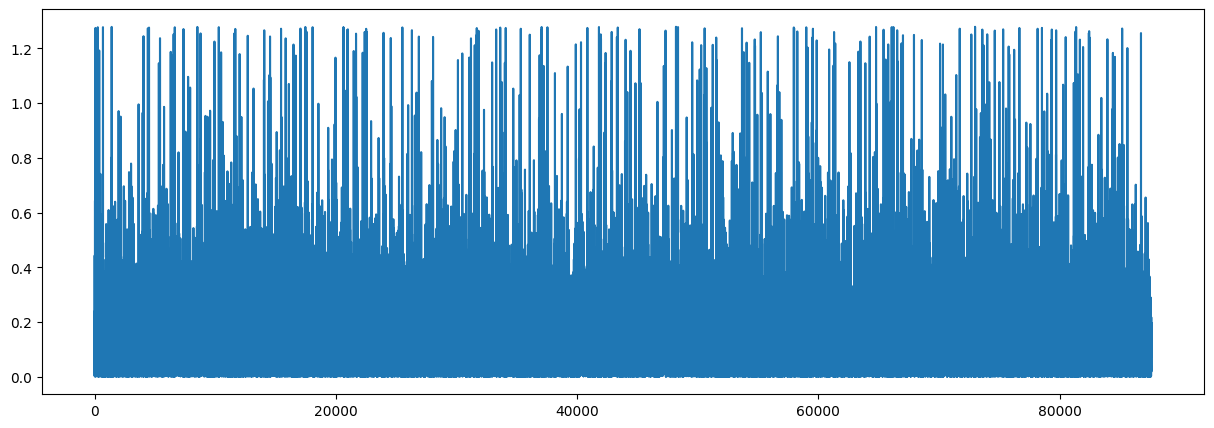


----------------- CO -----------------
------- Timeseries -------


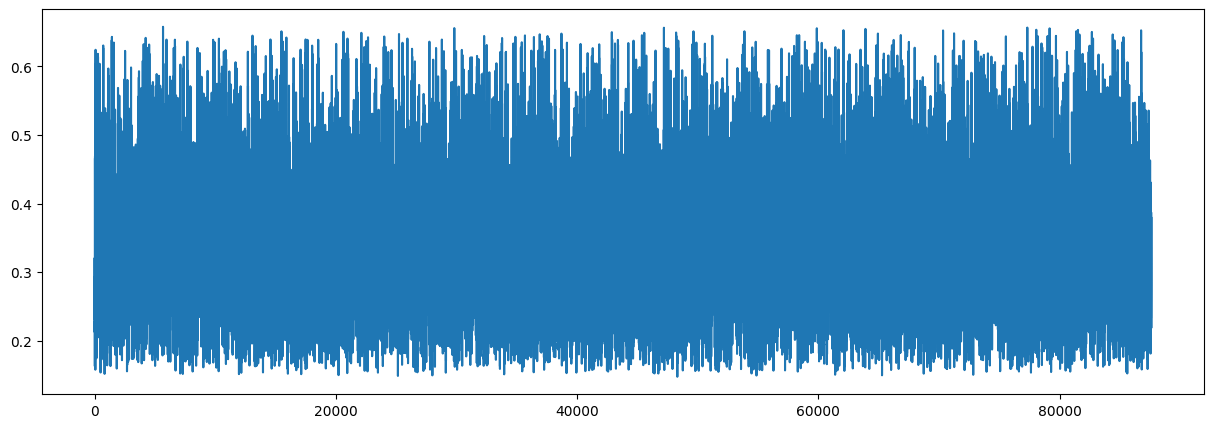


----------------- CO 8H -----------------
------- Timeseries -------


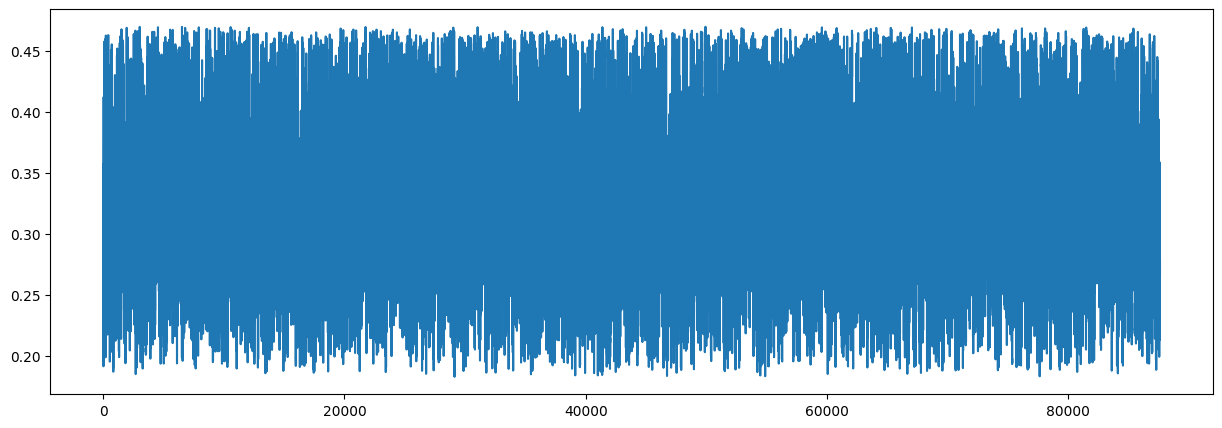


----------------- ETILBENCENO -----------------
------- Timeseries -------


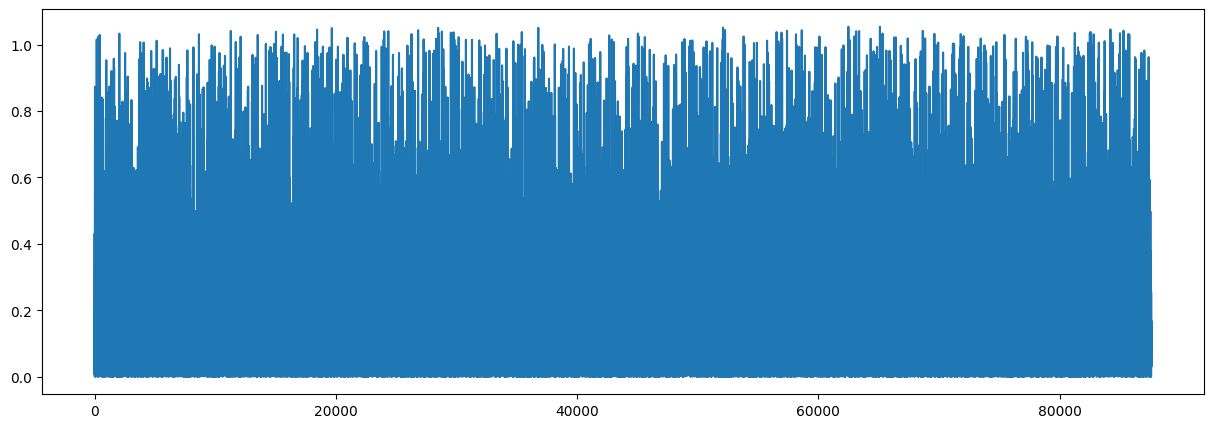


----------------- NO -----------------
------- Timeseries -------


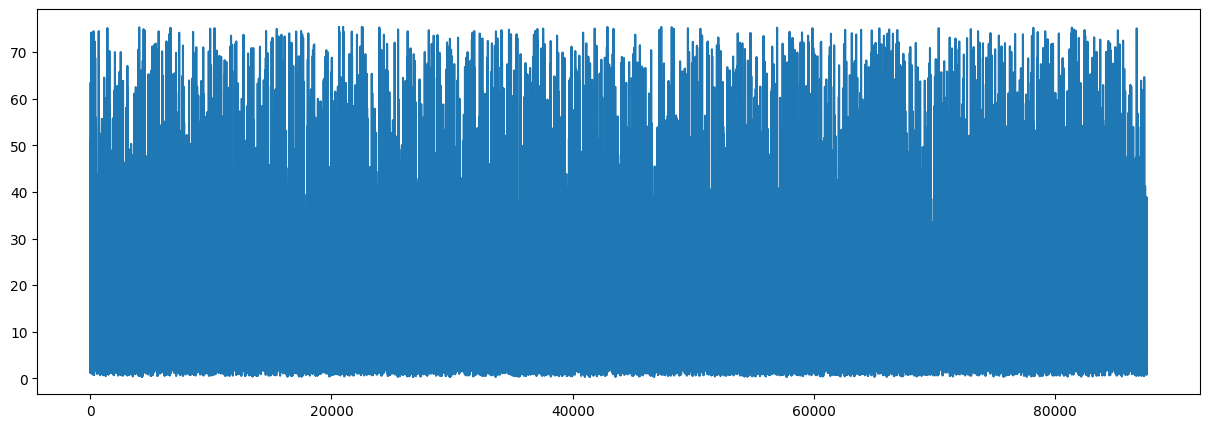


----------------- NO2 -----------------
------- Timeseries -------


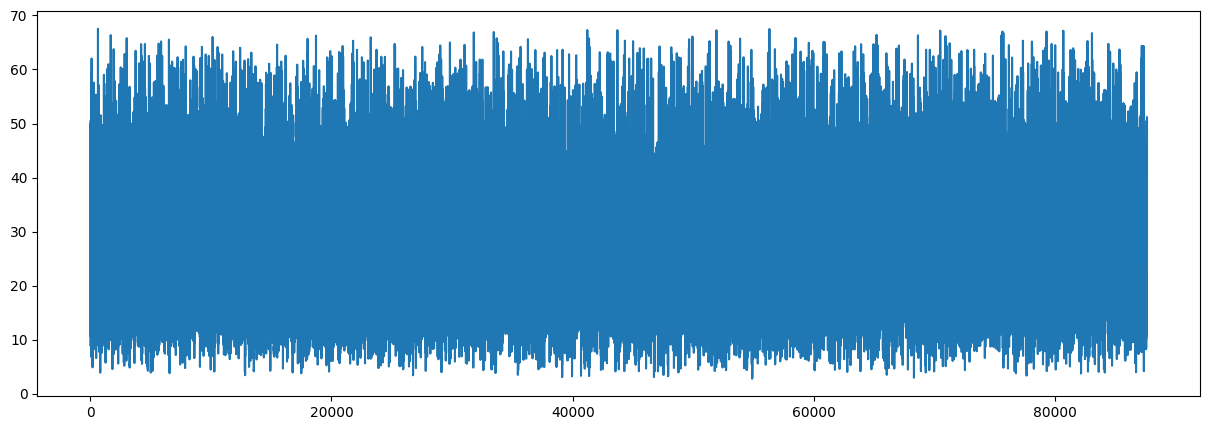


----------------- NOX -----------------
------- Timeseries -------


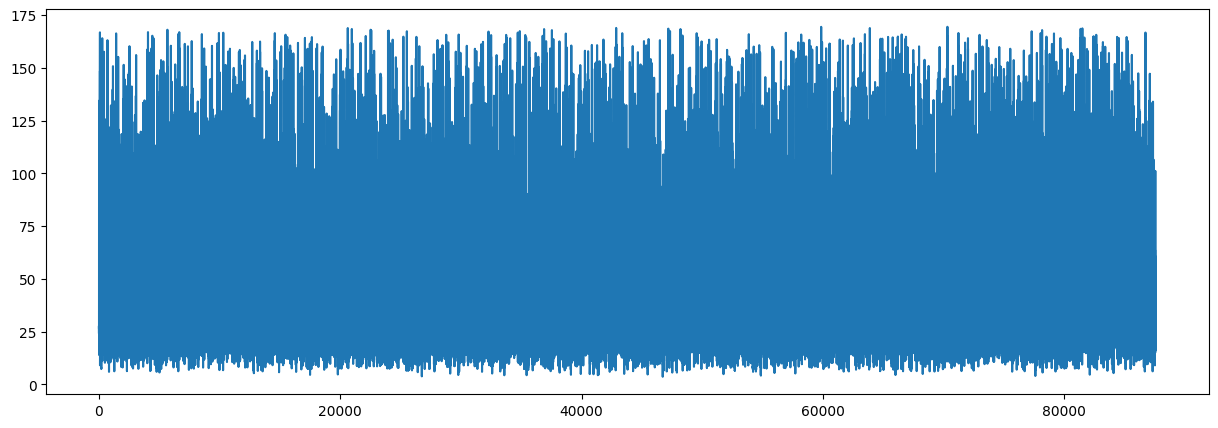


----------------- O3 -----------------
------- Timeseries -------


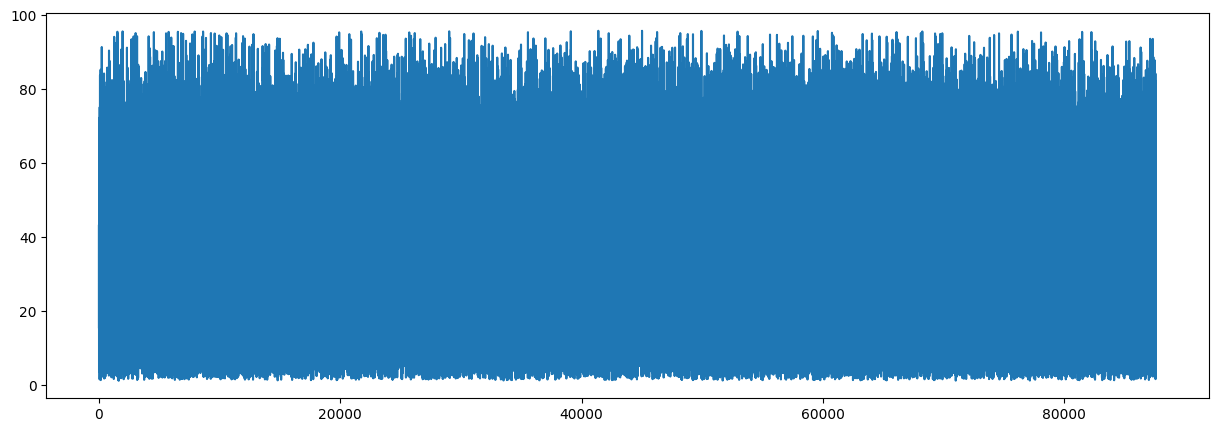


----------------- O3 8H -----------------
------- Timeseries -------


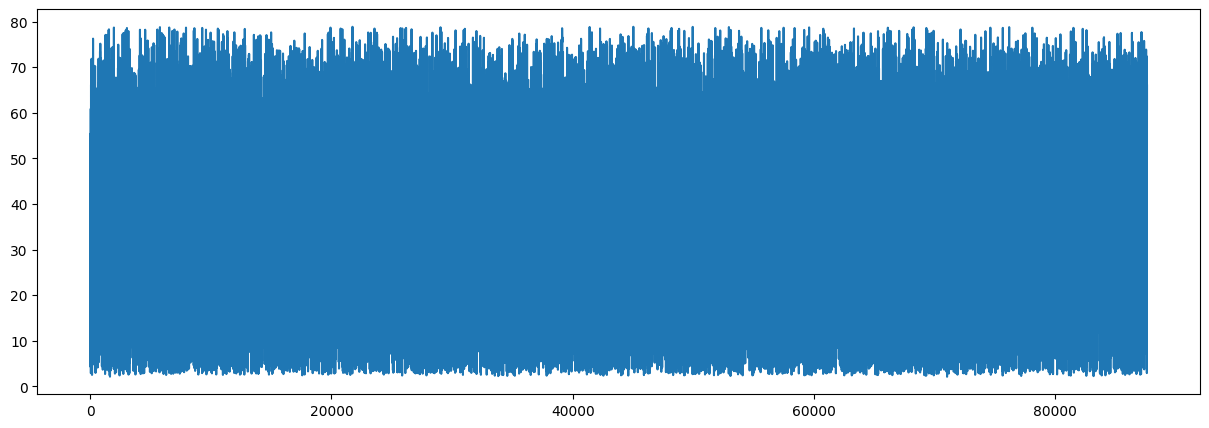


----------------- ORTOXILENO -----------------
------- Timeseries -------


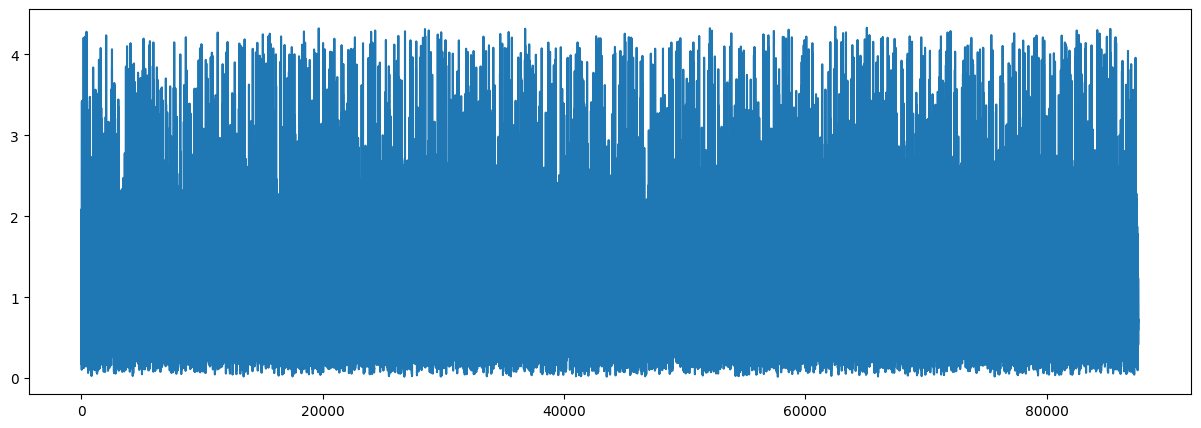


----------------- PM10 -----------------
------- Timeseries -------


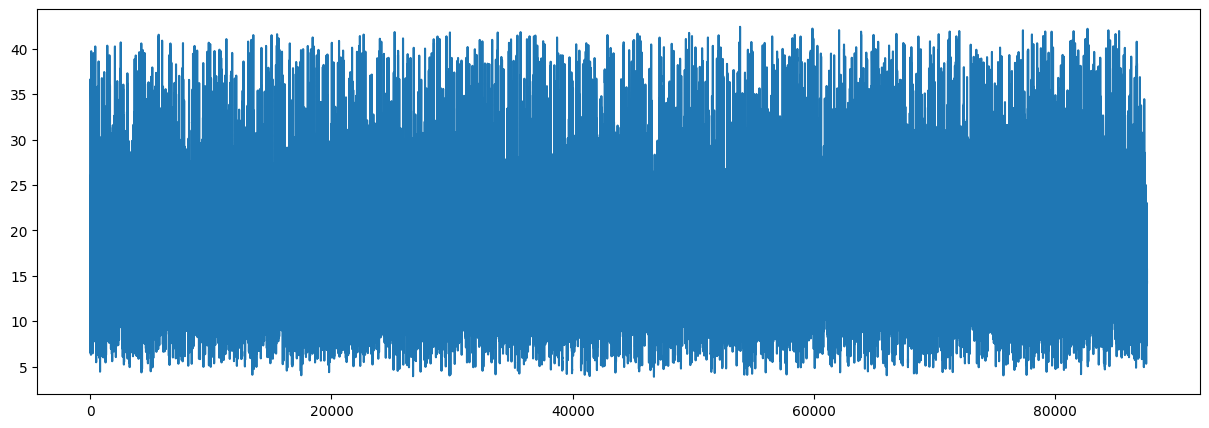


----------------- PM2.5 -----------------
------- Timeseries -------


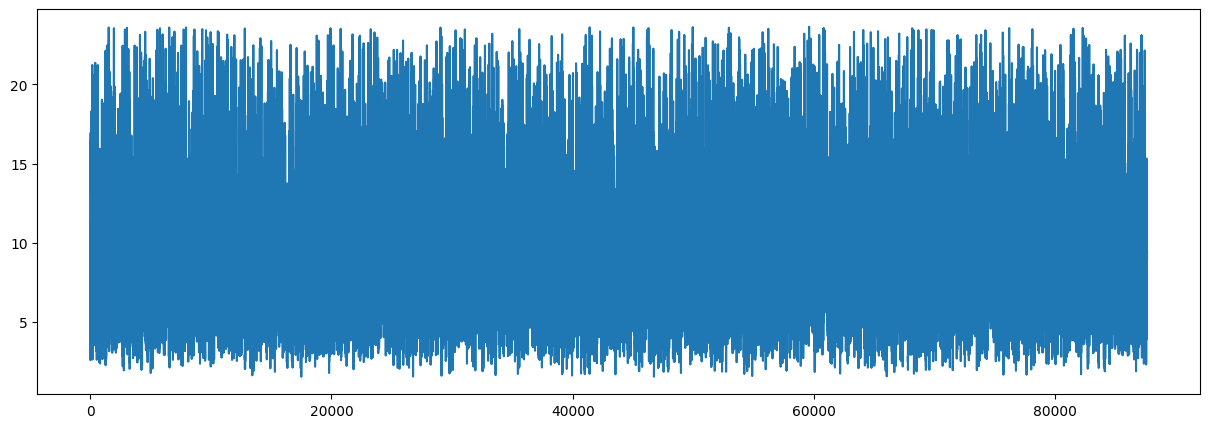


----------------- SO2 -----------------
------- Timeseries -------


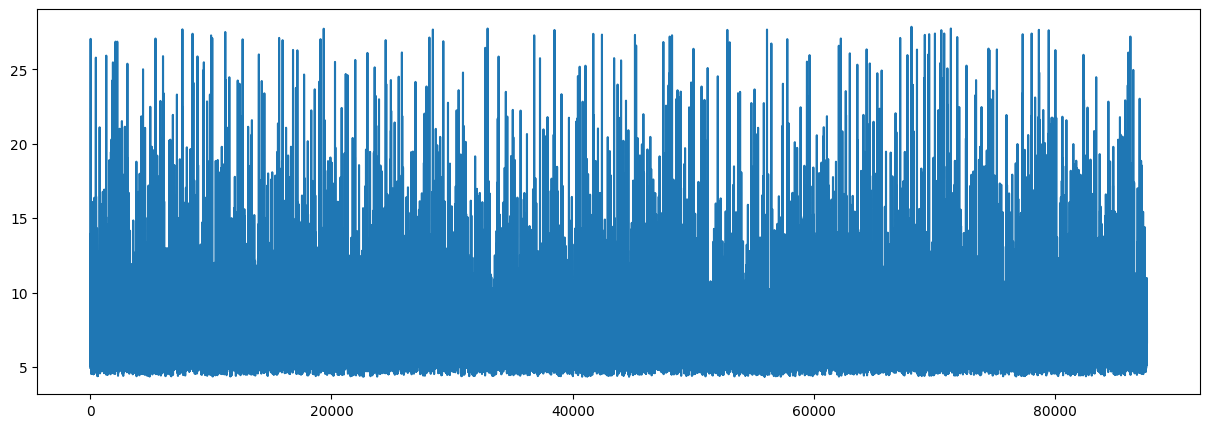


----------------- TOLUENO -----------------
------- Timeseries -------


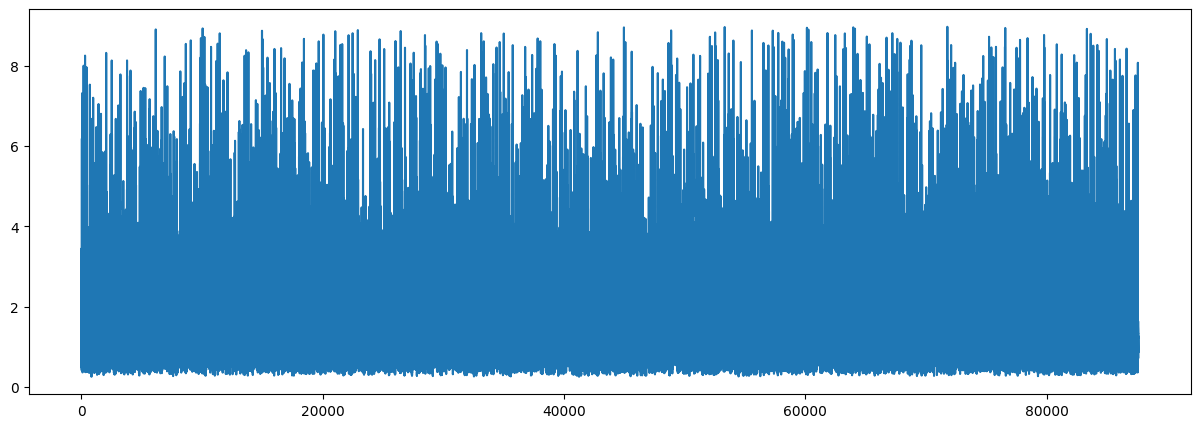


----------------- DIRECWIND -----------------
------- Timeseries -------


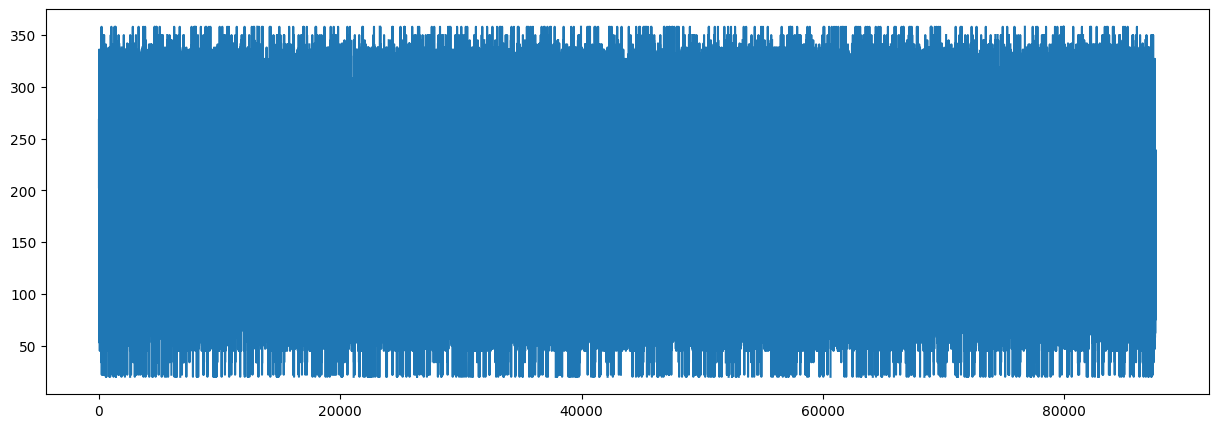


----------------- HUMID -----------------
------- Timeseries -------


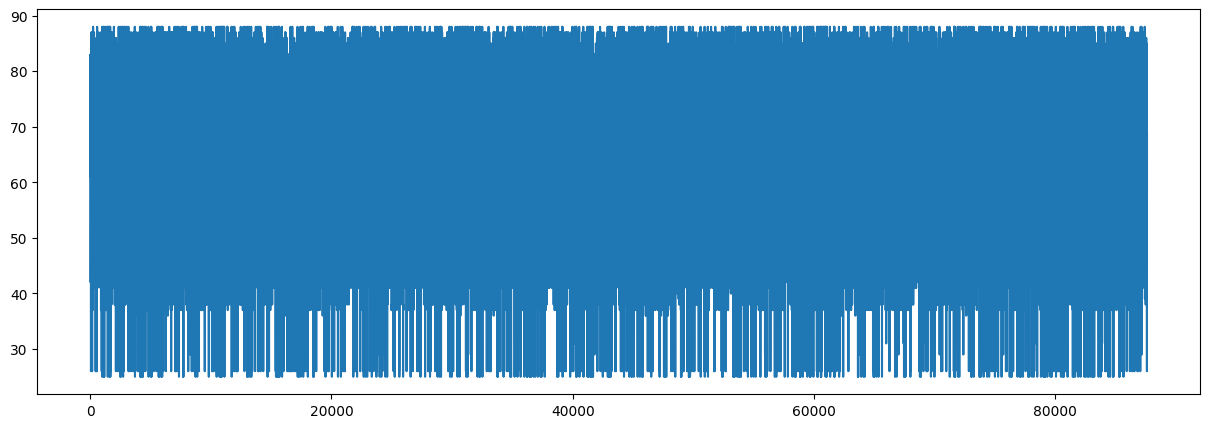


----------------- PRECIP -----------------
------- Timeseries -------


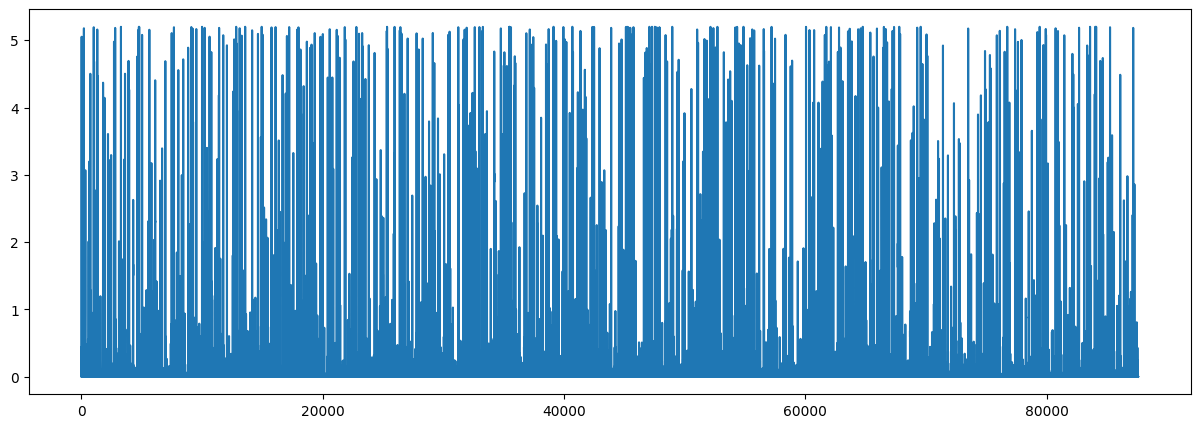


----------------- TEMP -----------------
------- Timeseries -------


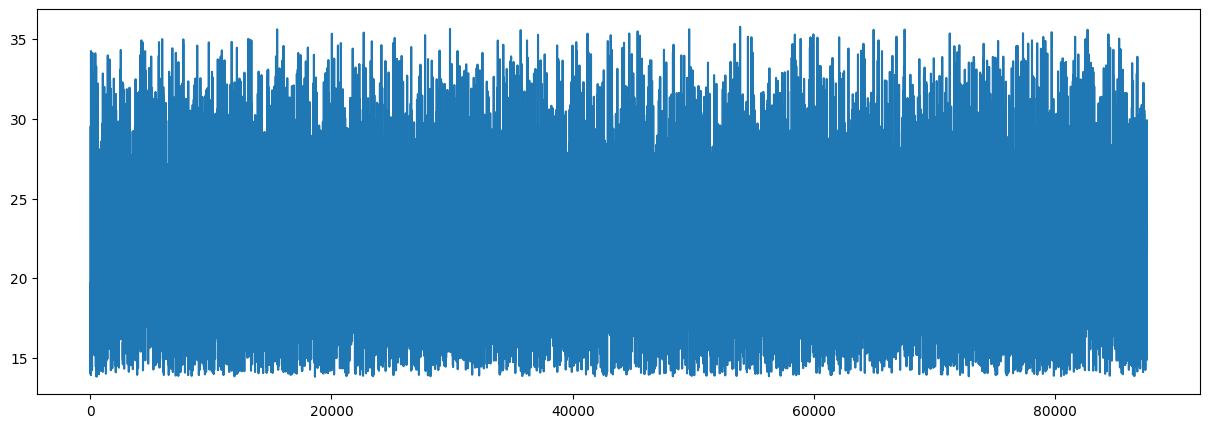


----------------- SPEEDWIND -----------------
------- Timeseries -------


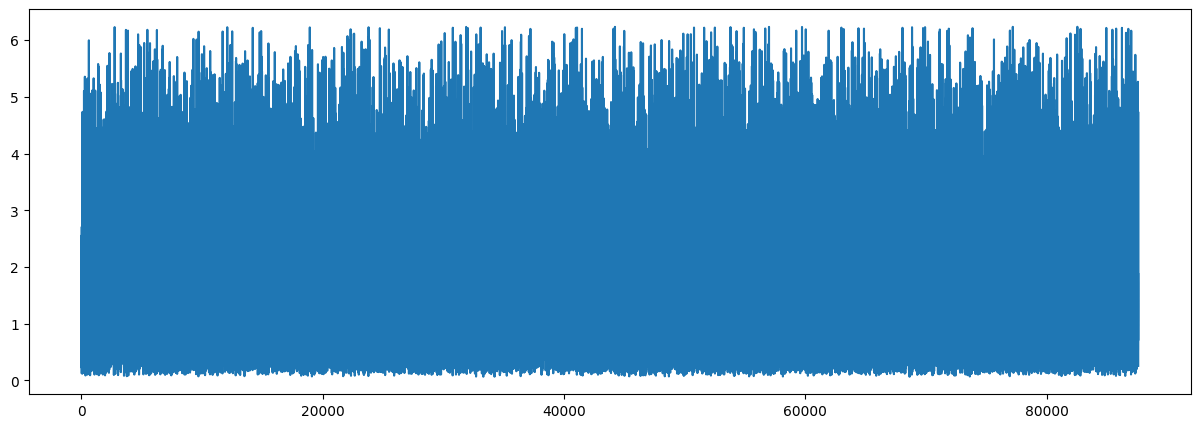


----------------- CAR -----------------
------- Timeseries -------


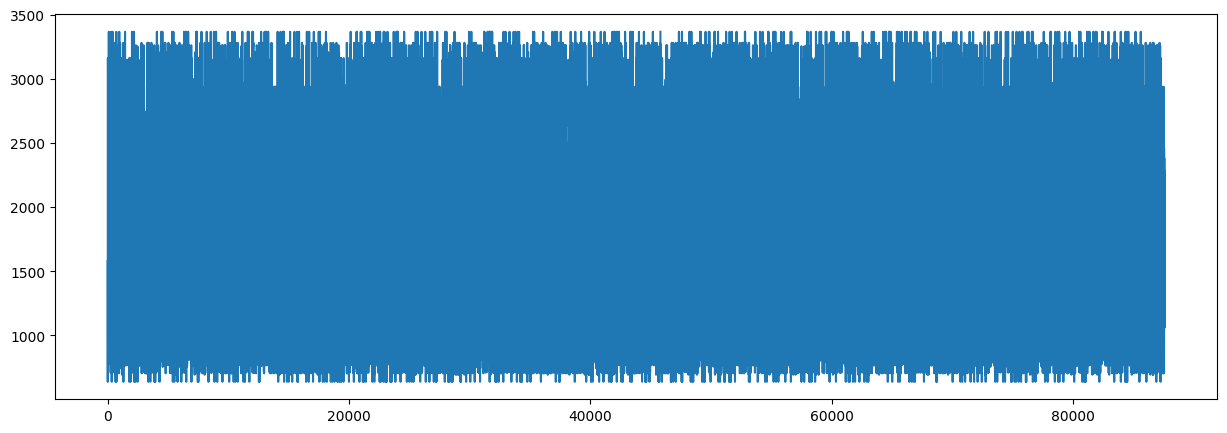


----------------- MOTORCYCLE -----------------
------- Timeseries -------


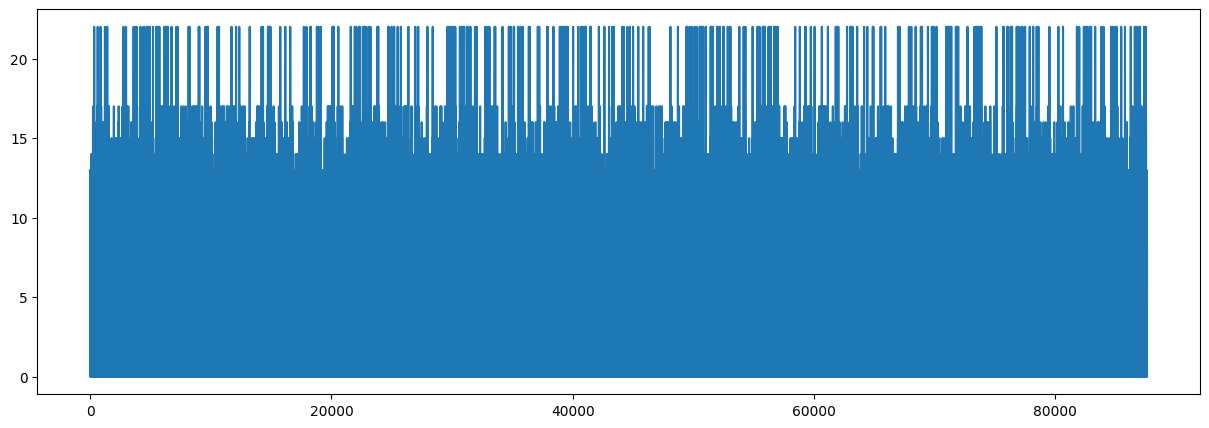


----------------- BUS -----------------
------- Timeseries -------


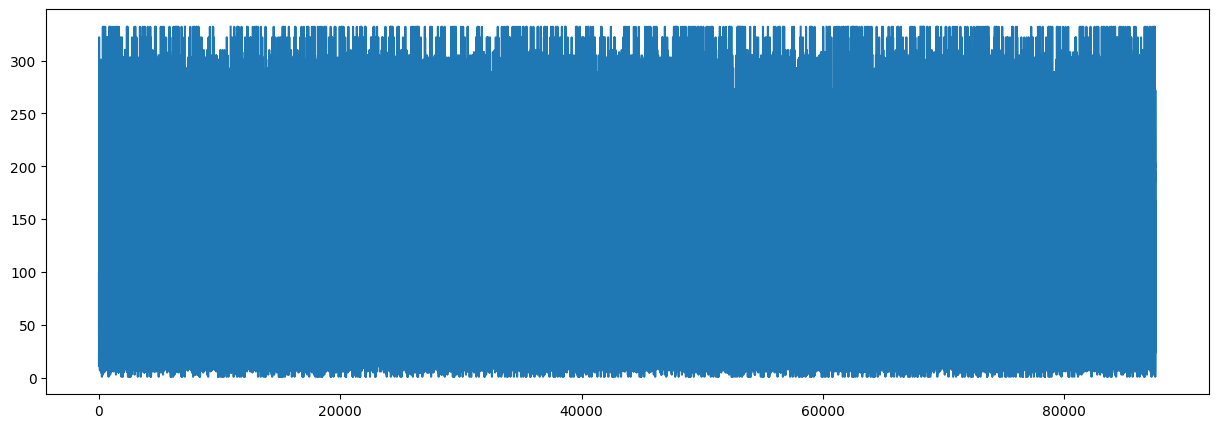


----------------- TRUCK -----------------
------- Timeseries -------


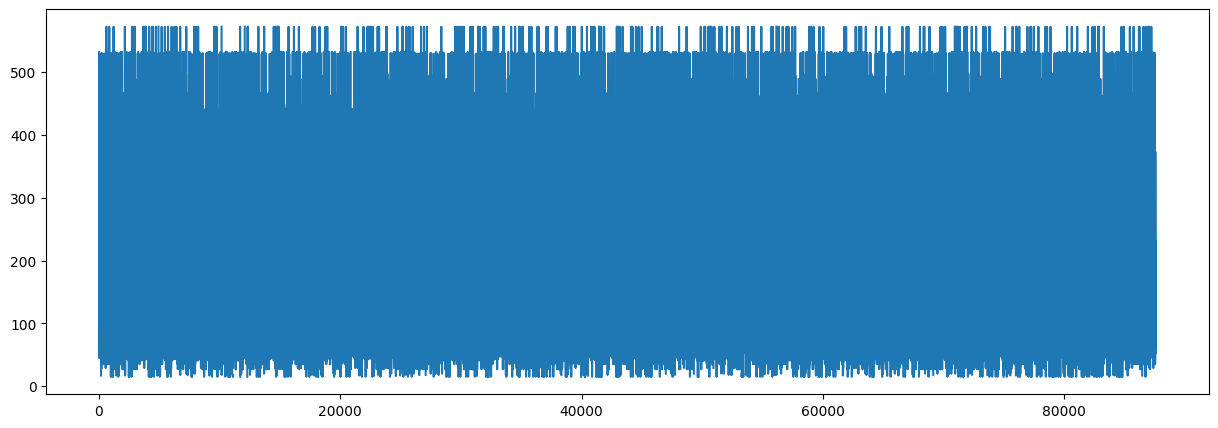


------------------------------------- MADRID -------------------------------------
------- Dataset description -------
            CO       O3     PM10    PM2.5      SO2  SpeedWind  DirecWind  \
count  421.000  421.000  421.000  421.000  421.000    421.000    421.000   
mean     0.336   55.380   15.873    8.284    1.172      0.813     90.404   
std      0.140   29.259    7.918    3.969    0.301      0.498     89.659   
min      0.175    4.308    3.833    1.667    1.000      0.350      0.000   
25%      0.250   32.333    9.583    5.286    1.000      0.420     13.000   
50%      0.300   52.154   13.727    7.429    1.000      0.680     50.000   
75%      0.367   76.333   20.385   10.429    1.250      1.030    171.000   
max      1.150  133.000   40.769   22.500    3.000      2.680    337.000   

          Temp    Humid   Precip       Car  Motorcycle      Bus    Truck  
count  421.000  421.000  421.000   421.000     421.000  421.000  421.000  
mean    19.349   65.796    0.045   881.665   

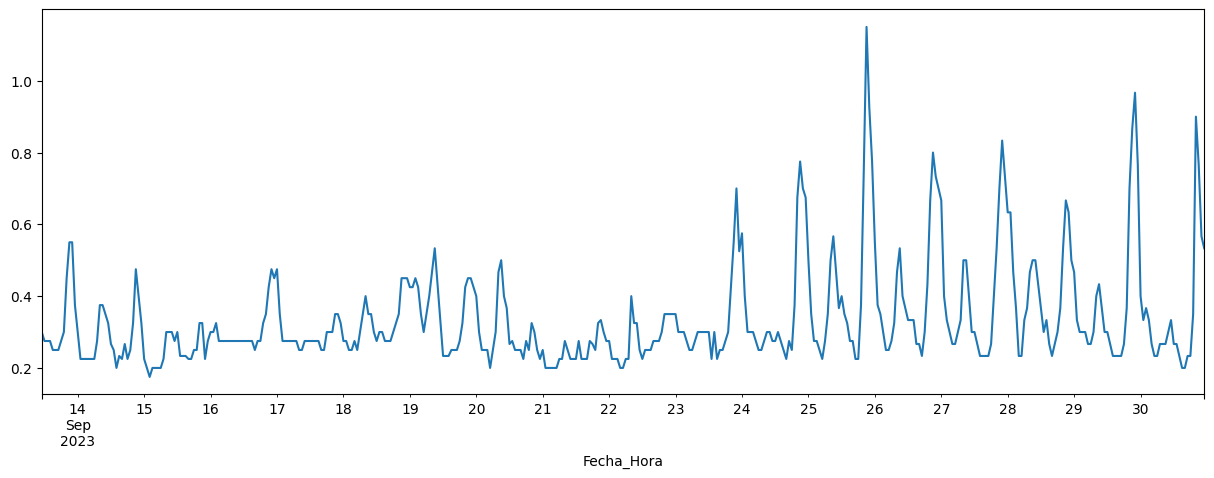


----------------- O3 -----------------
------- Timeseries -------


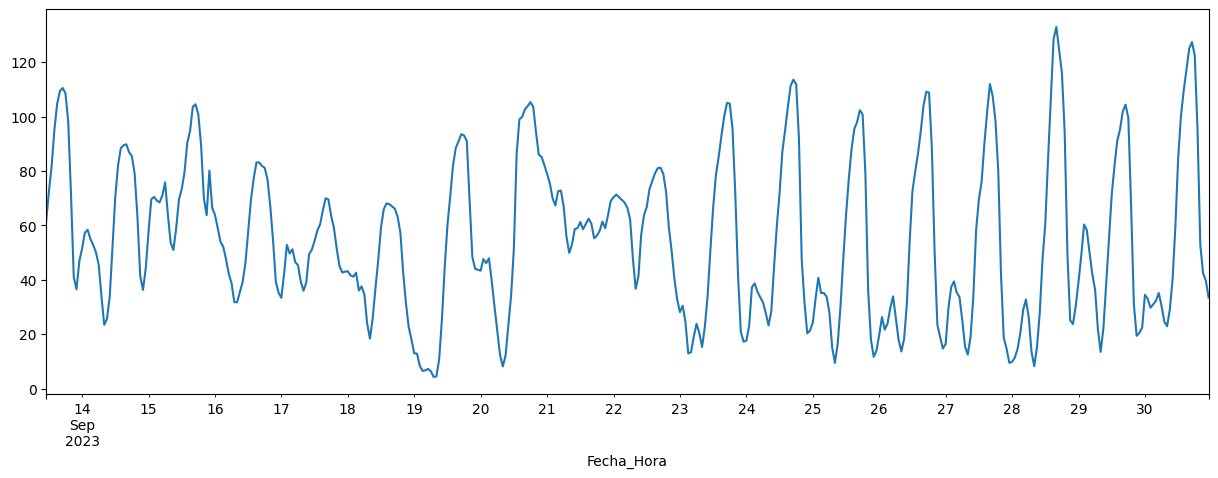


----------------- PM10 -----------------
------- Timeseries -------


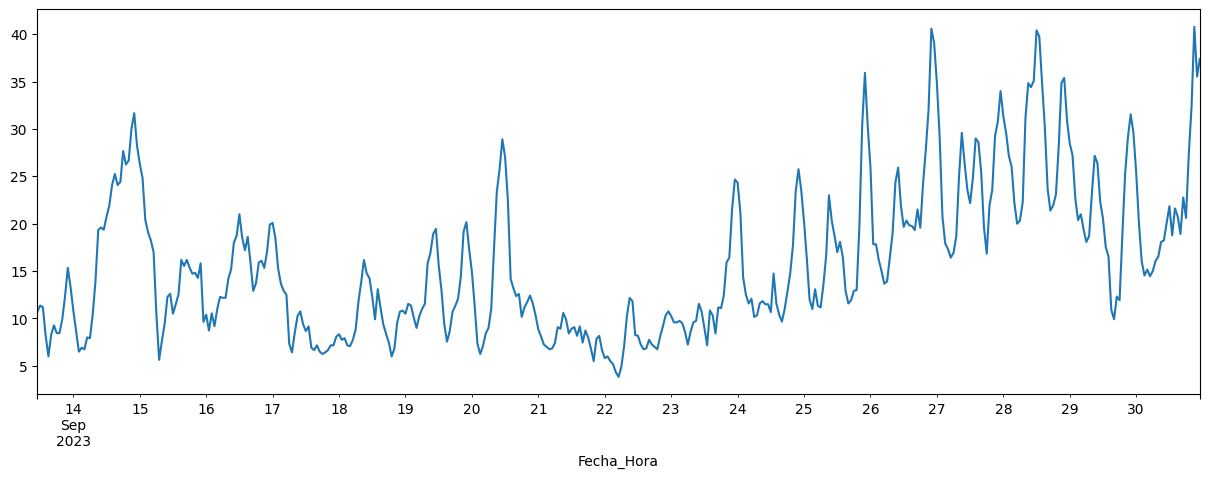


----------------- PM2.5 -----------------
------- Timeseries -------


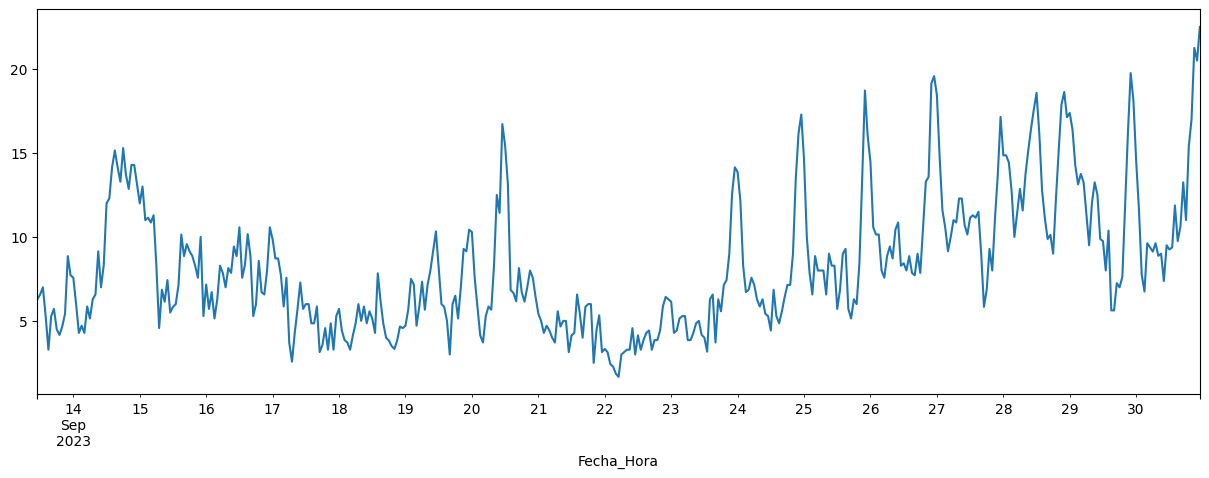


----------------- SO2 -----------------
------- Timeseries -------


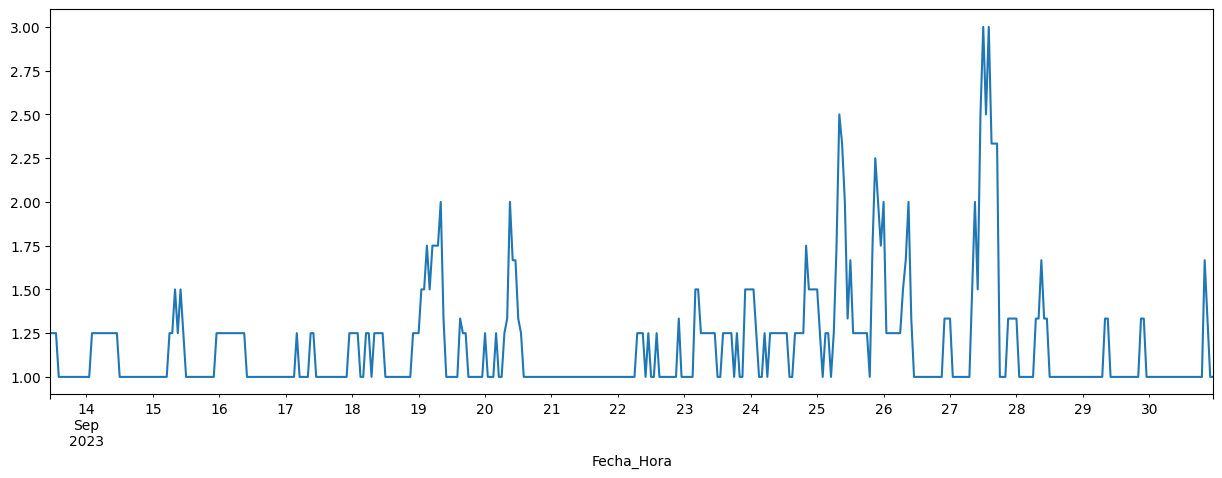


----------------- SPEEDWIND -----------------
------- Timeseries -------


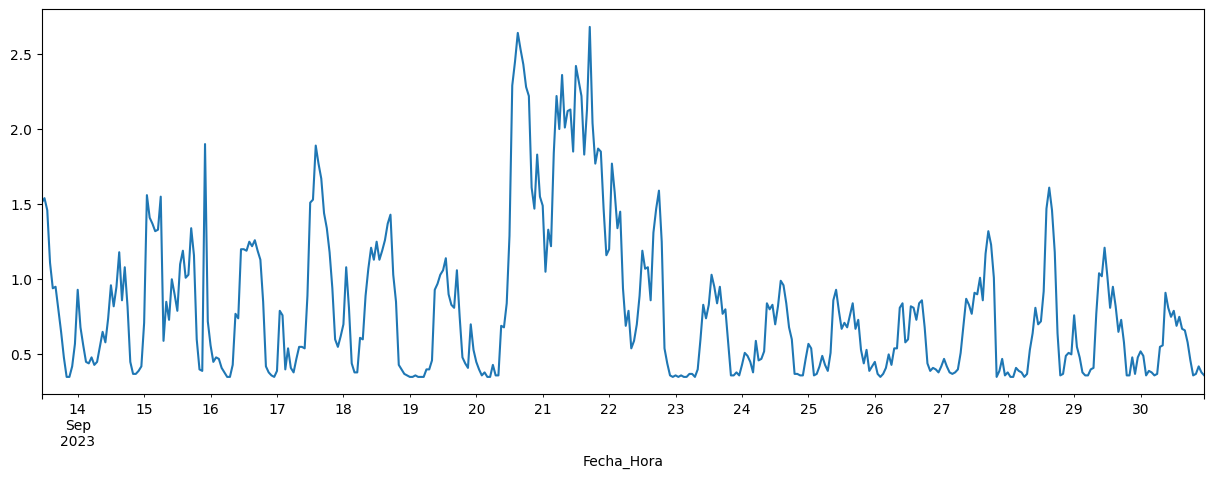


----------------- DIRECWIND -----------------
------- Timeseries -------


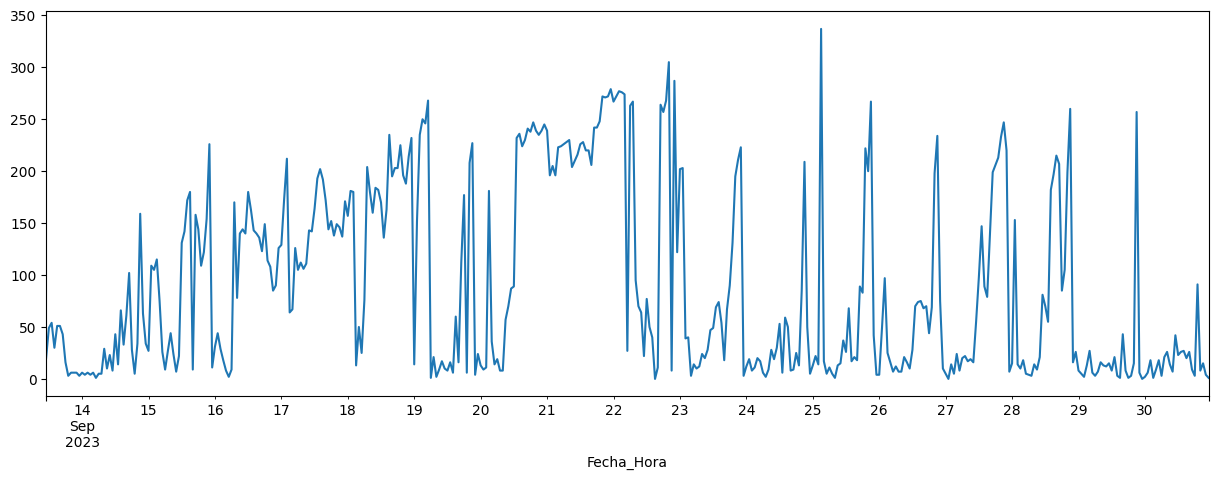


----------------- TEMP -----------------
------- Timeseries -------


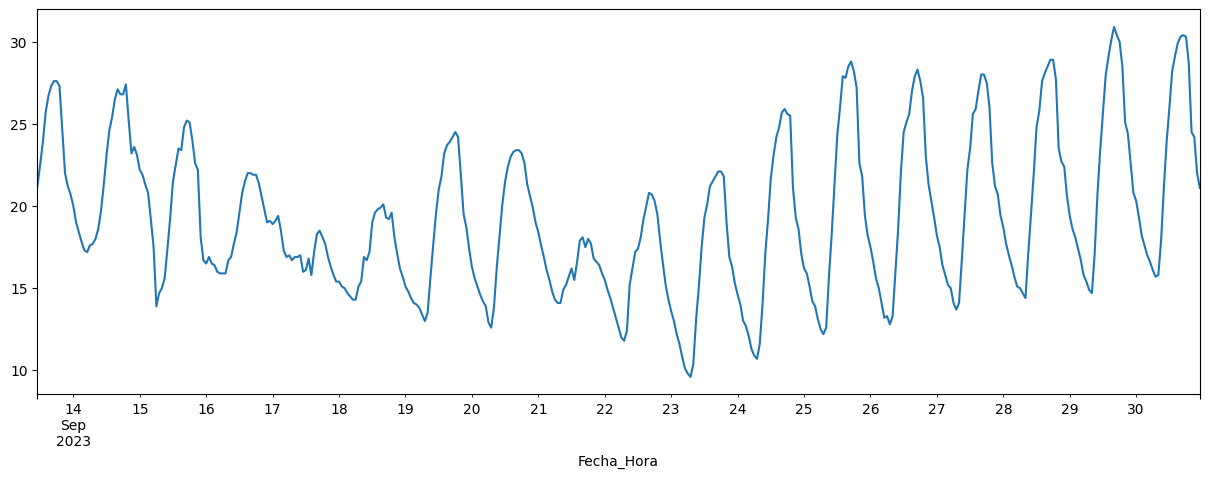


----------------- HUMID -----------------
------- Timeseries -------


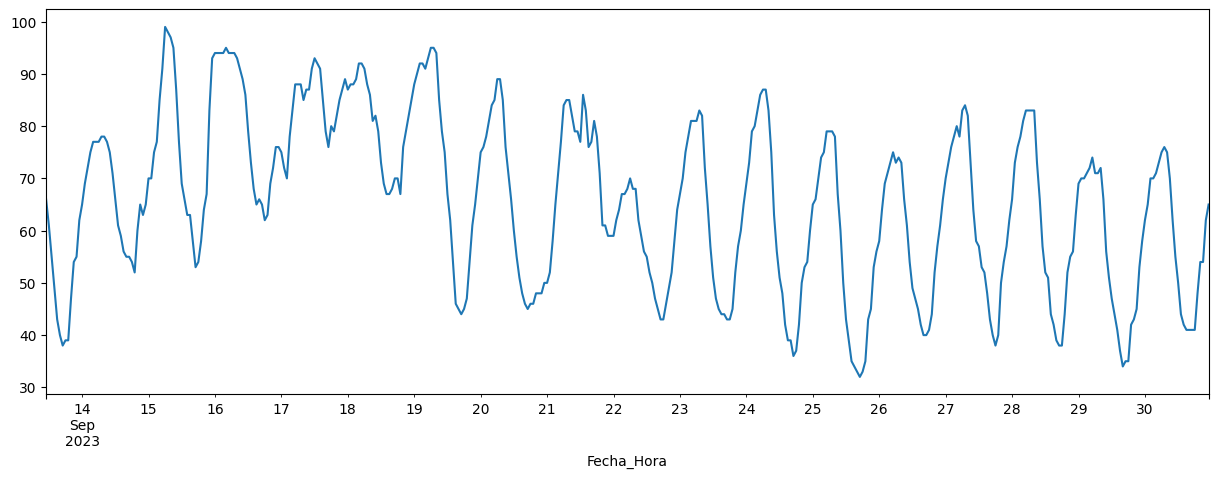


----------------- PRECIP -----------------
------- Timeseries -------


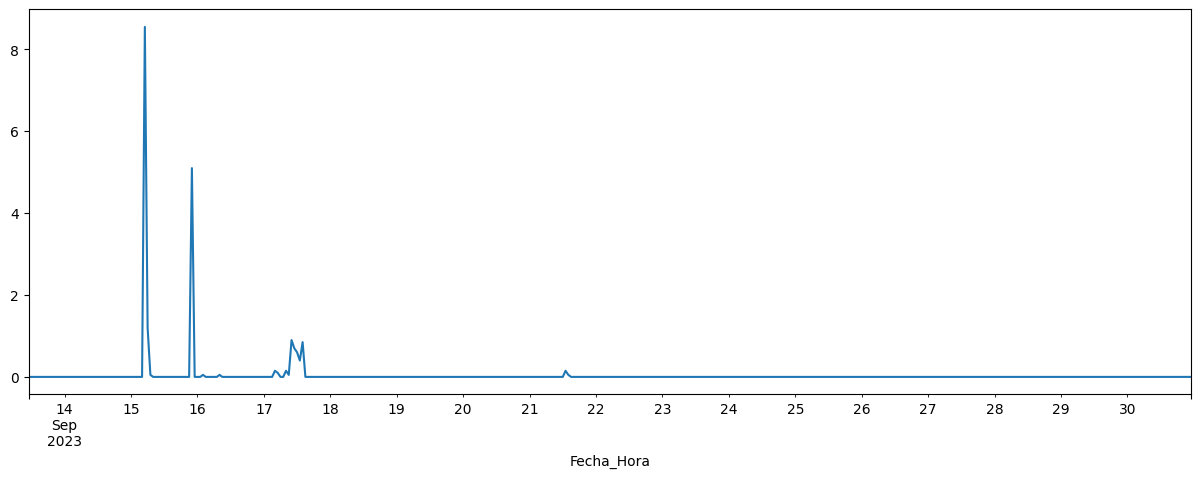


----------------- CAR -----------------
------- Timeseries -------


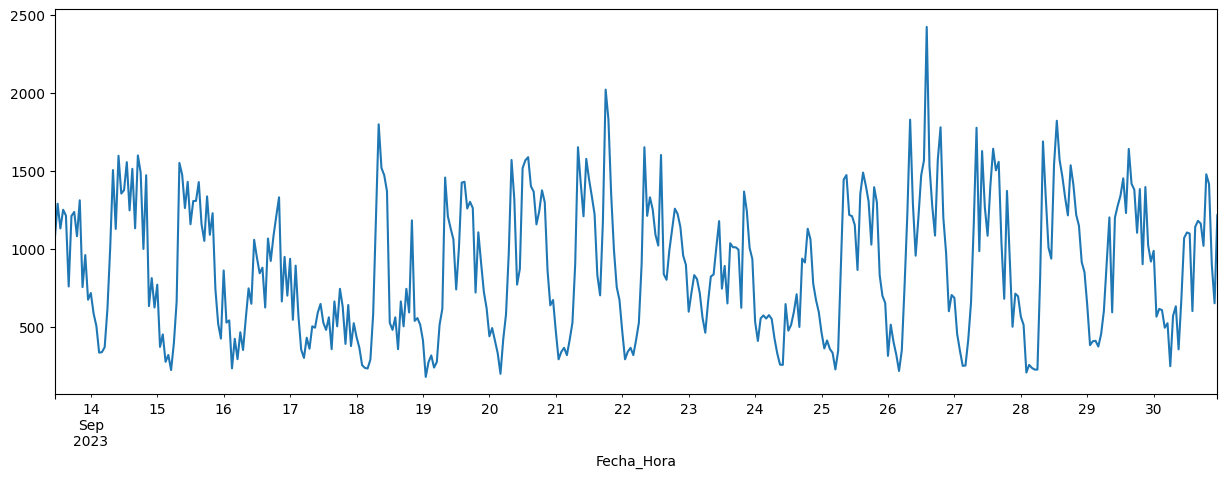


----------------- MOTORCYCLE -----------------
------- Timeseries -------


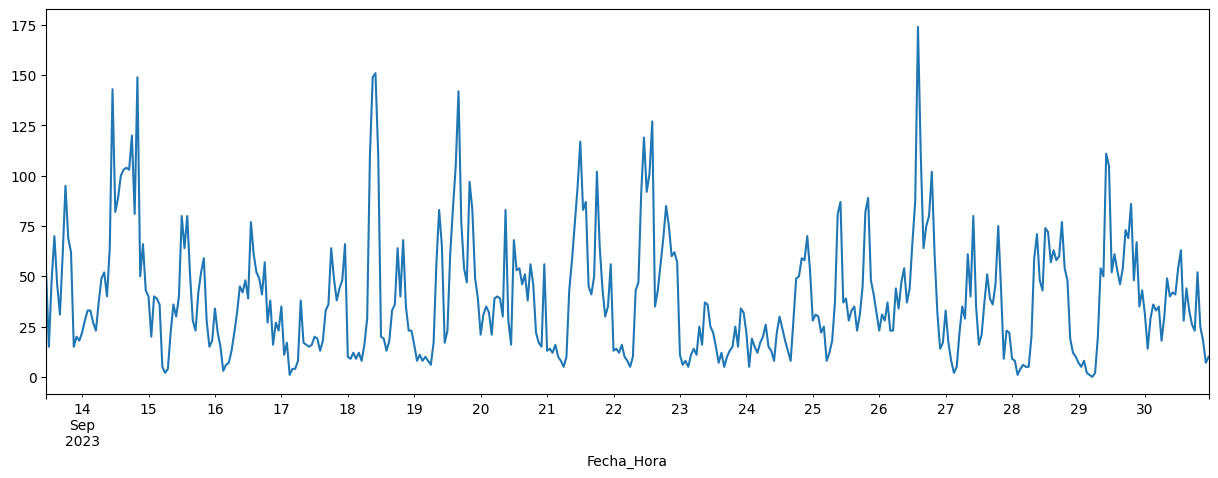


----------------- BUS -----------------
------- Timeseries -------


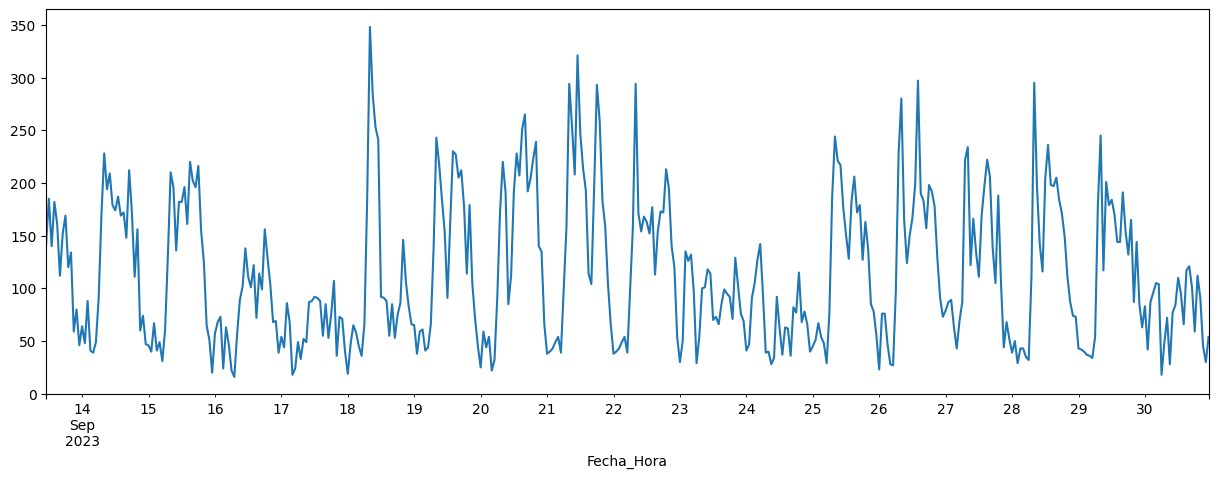


----------------- TRUCK -----------------
------- Timeseries -------


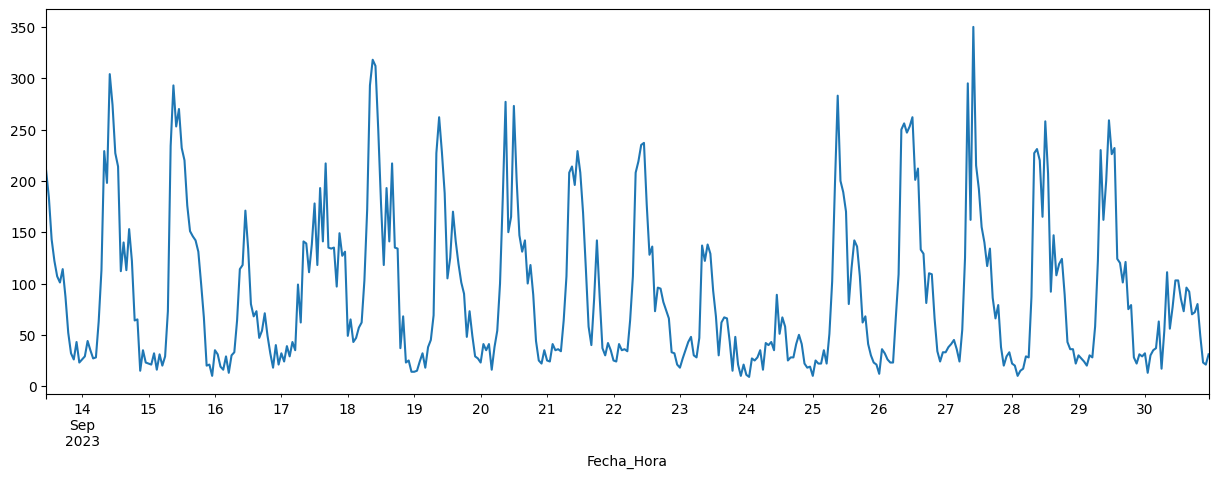


------------------------------------- MADRID SYNTH -------------------------------------
------- Dataset description -------
              CO         O3       PM10      PM2.5        SO2  SpeedWind  \
count  87600.000  87600.000  87600.000  87600.000  87600.000  87600.000   
mean       0.336     54.394     15.619      8.114      1.176      0.815   
std        0.137     29.018      7.283      3.616      0.298      0.484   
min        0.179      4.811      4.142      1.811      1.000      0.350   
25%        0.250     30.791     10.118      5.445      1.013      0.418   
50%        0.290     49.120     13.978      7.355      1.059      0.667   
75%        0.370     75.758     19.561     10.045      1.209      1.057   
max        1.147    131.421     40.496     19.694      3.000      2.674   

       DirecWind       Temp      Humid     Precip        Car  Motorcycle  \
count  85872.000  87600.000  87600.000  87600.000  85467.000   87600.000   
mean      97.349     19.151     66.191      0.

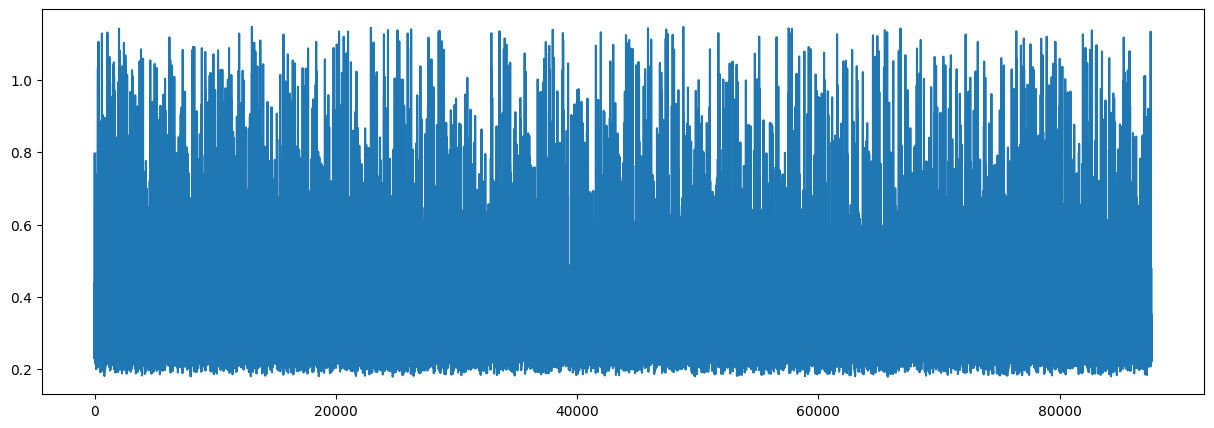


----------------- O3 -----------------
------- Timeseries -------


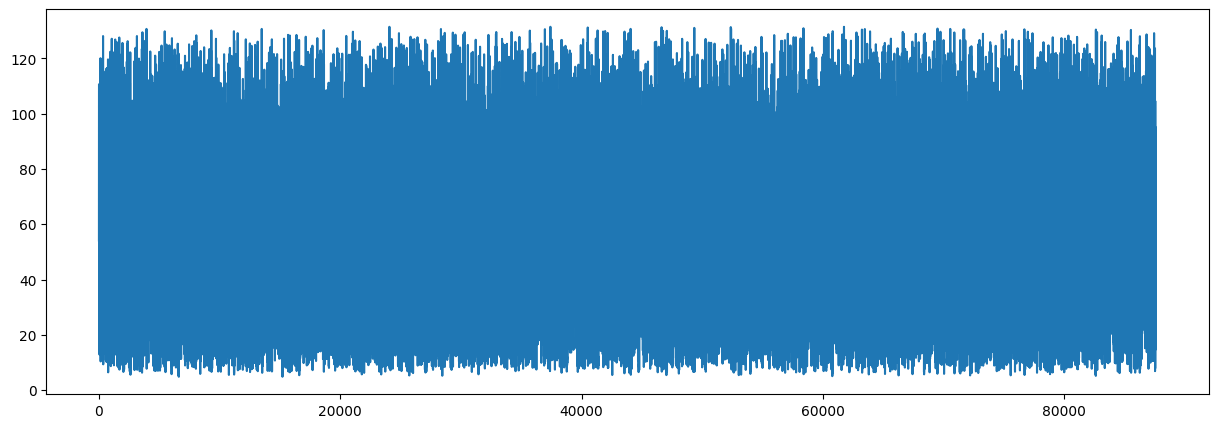


----------------- PM10 -----------------
------- Timeseries -------


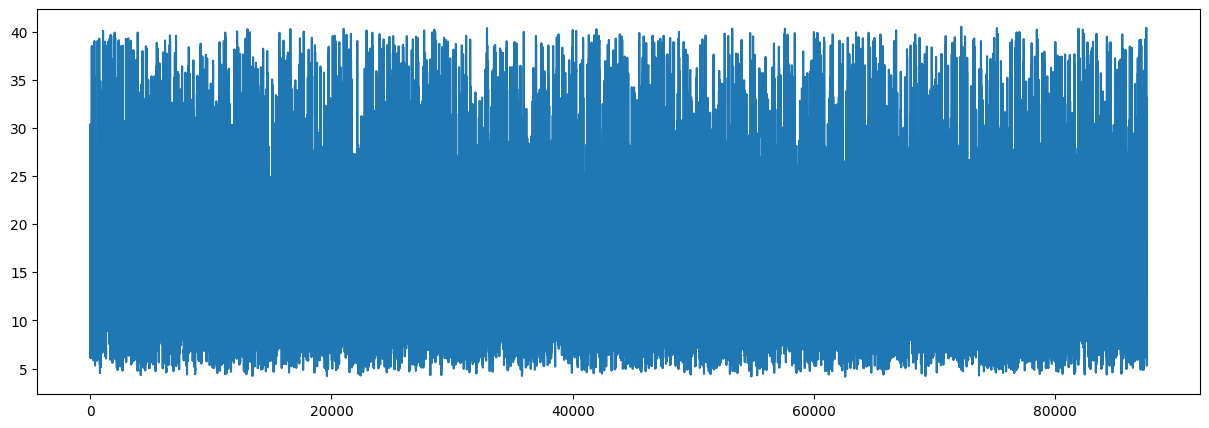


----------------- PM2.5 -----------------
------- Timeseries -------


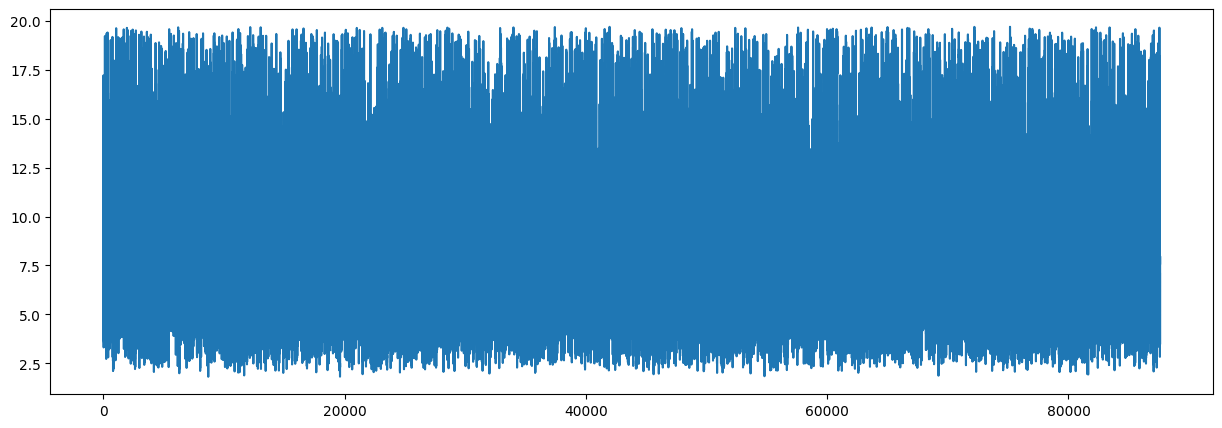


----------------- SO2 -----------------
------- Timeseries -------


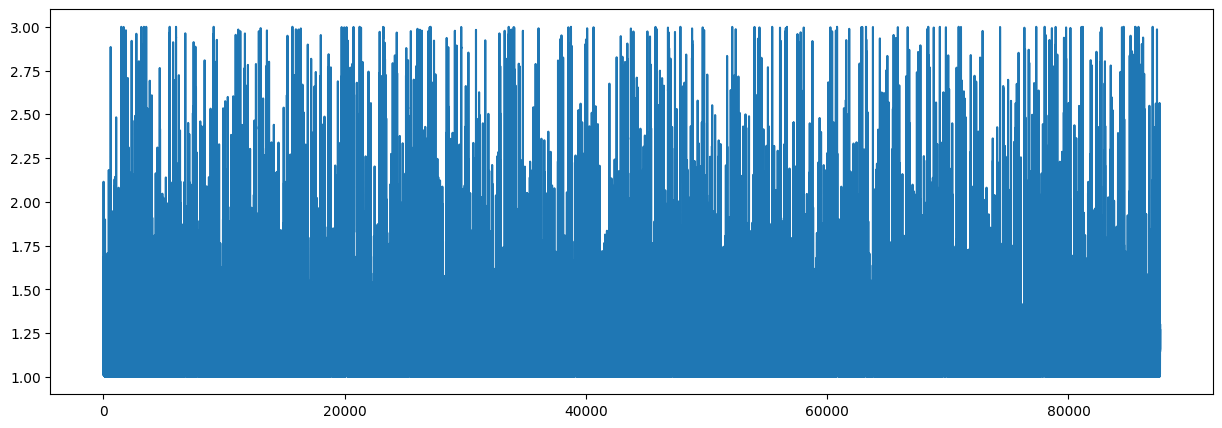


----------------- SPEEDWIND -----------------
------- Timeseries -------


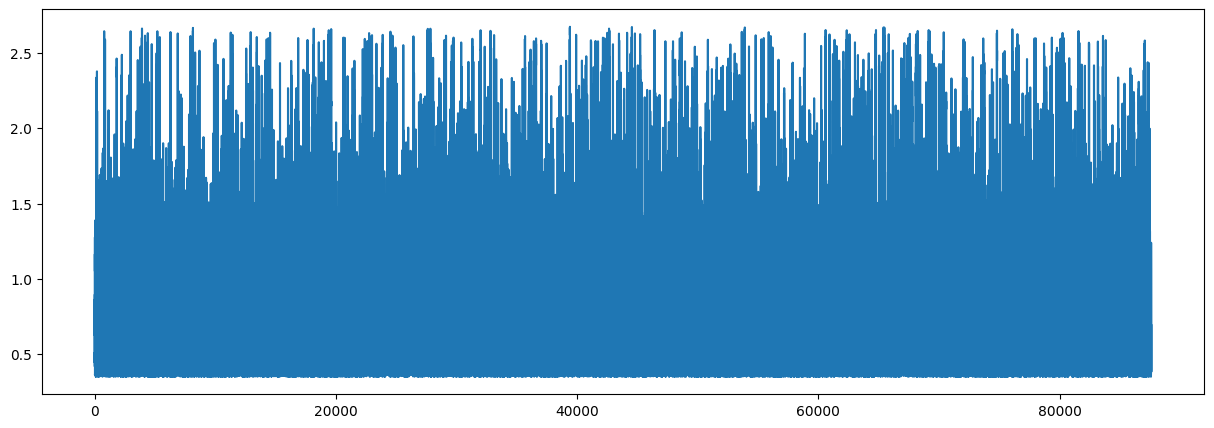


----------------- DIRECWIND -----------------
------- Timeseries -------


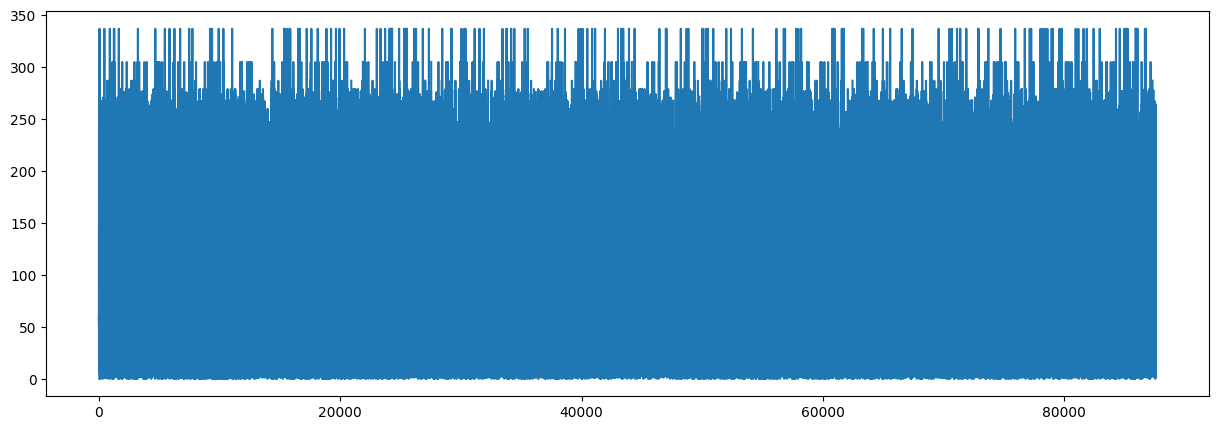


----------------- TEMP -----------------
------- Timeseries -------


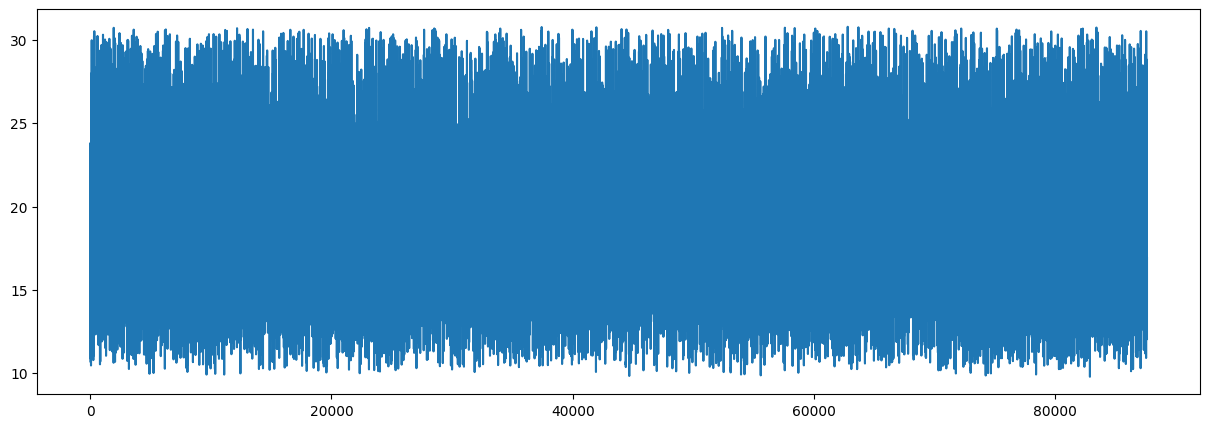


----------------- HUMID -----------------
------- Timeseries -------


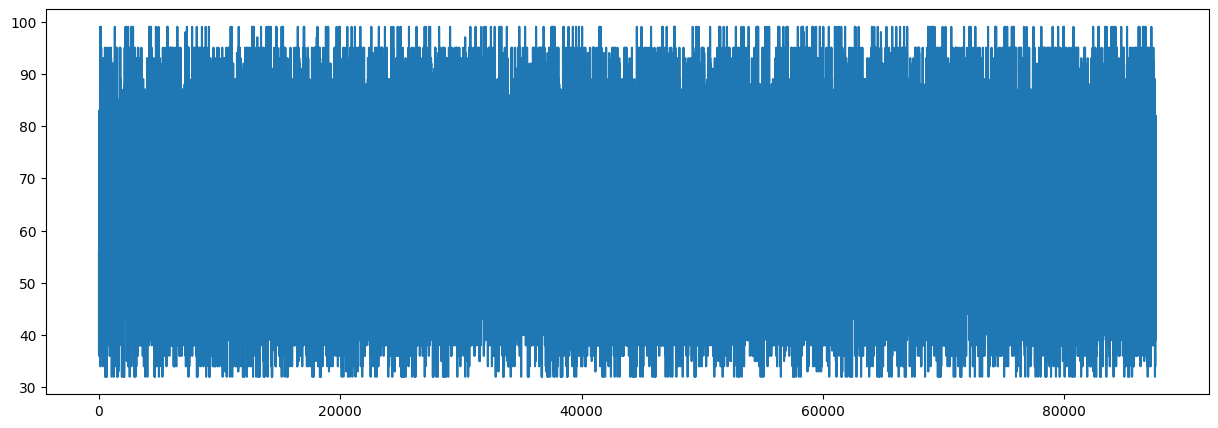


----------------- PRECIP -----------------
------- Timeseries -------


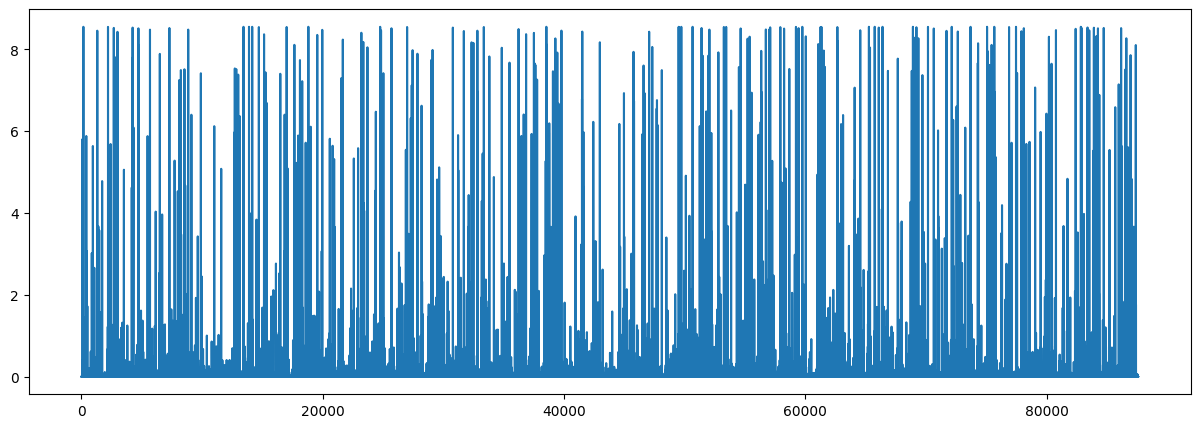


----------------- CAR -----------------
------- Timeseries -------


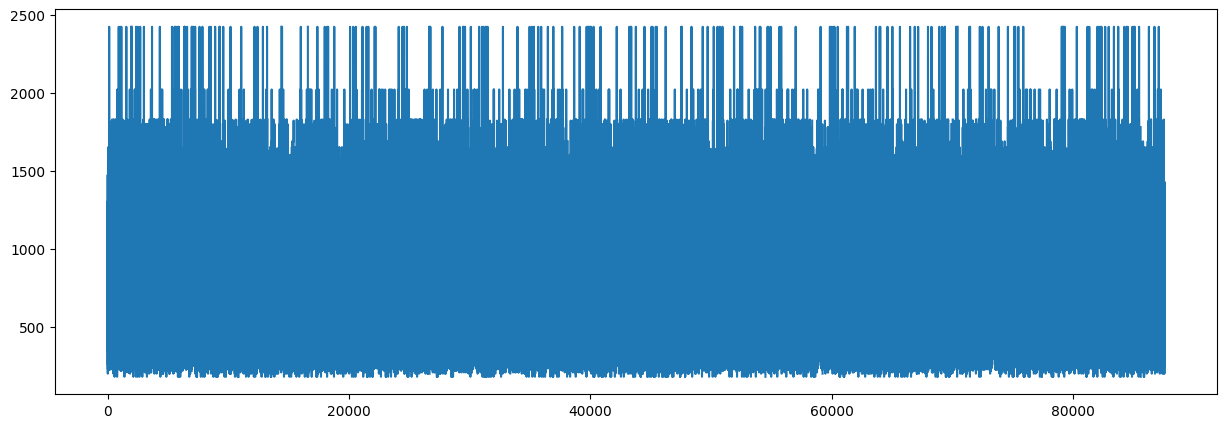


----------------- MOTORCYCLE -----------------
------- Timeseries -------


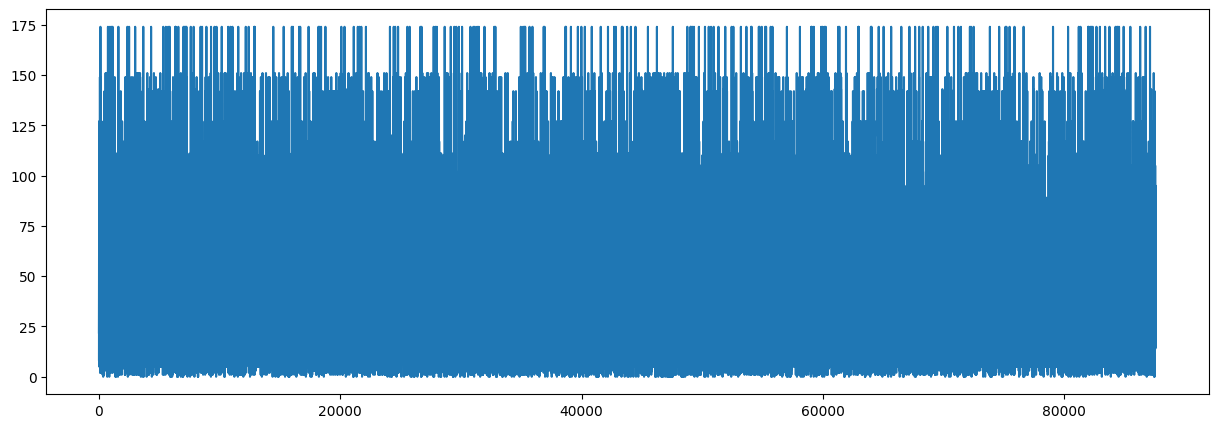


----------------- BUS -----------------
------- Timeseries -------


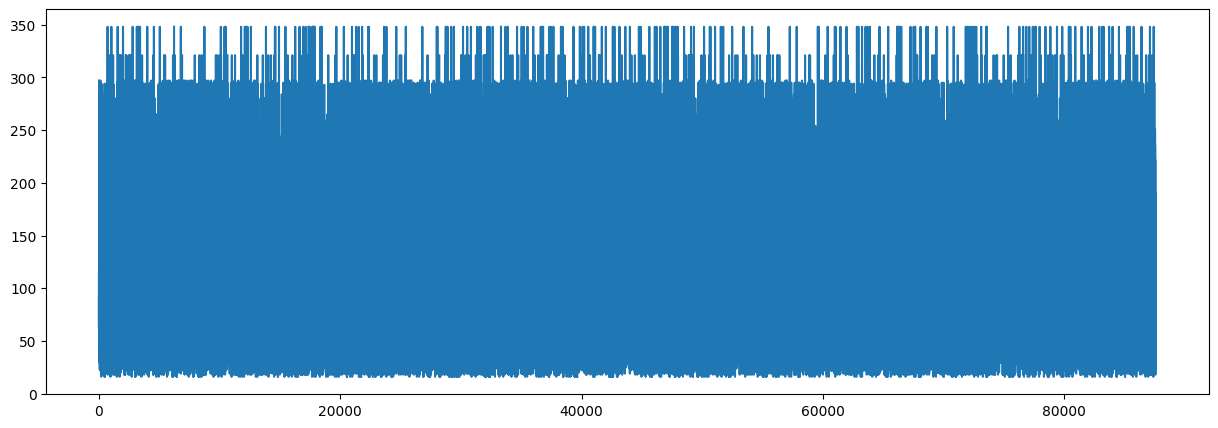


----------------- TRUCK -----------------
------- Timeseries -------


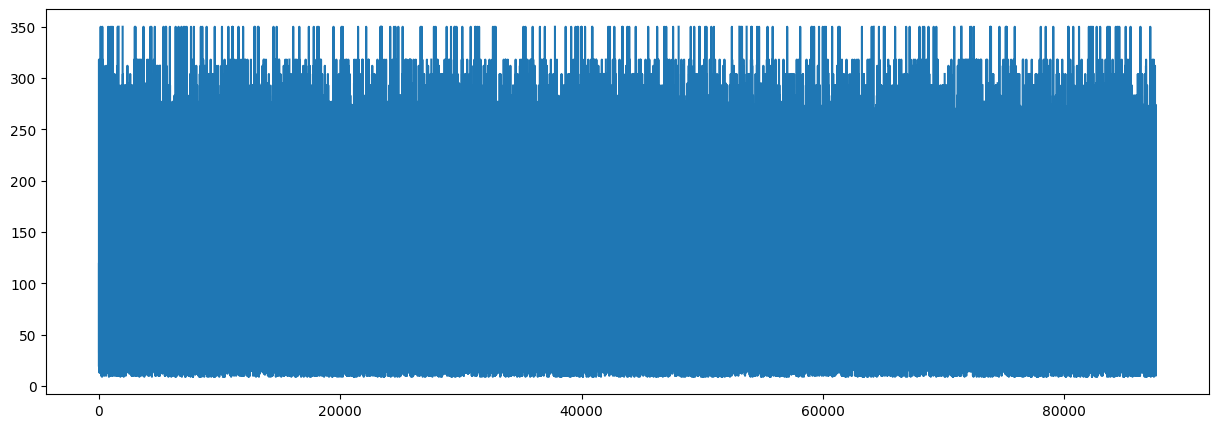


CPU times: user 29.9 s, sys: 15.9 s, total: 45.8 s
Wall time: 26.6 s


In [4]:
%%time

# Iterate over all possible train datasets
for key, dataset in datasets.items():
    
    # Print a header
    print('-' * 37, key.upper(), '-' * 37)
    
    # Print dataaset description
    print('-' * 7, 'Dataset description', '-' * 7)
    print(dataset.describe().round(3))
    print()
    """
    
    # Print dataaset description
    print('-' * 7, 'LATEX - Dataset description', '-' * 7)
    print(dataset.describe().round(3).to_latex())
    print()
    """
    
    """
    # Print variable ranges
    print('-' * 7, 'Date range for each variable', '-' * 7)
    for column in dataset.columns:
        print(f'\t{column}')
        print(f'\t\tMinimum date: {dataset[[column]].dropna().index.min()}')
        print(f'\t\tMaximum date: {dataset[[column]].dropna().index.max()}')
    print()
    """
        
    # Print variable correlations
    print('-' * 7, 'Dataset correlation', '-' * 7)
    print(dataset.corr().round(3))
    print()

    """
    # Print variable correlations
    print('-' * 7, 'LATEX - Dataset correlation', '-' * 7)
    print(dataset.corr().round(3).to_latex())
    print()
    """

    # Iterate over all possible variables
    for serie_key, serie_dataset in dataset.items():

        # Print a header
        print('-' * 17, serie_key.upper(), '-' * 17)
    
        """
        # Auxiliar variables
        freq = int(key.split('-')[-1])
        reg_per_hour = int(60/freq)
        lags = 2 * 24 * reg_per_hour

        # Plot ACF
        print('-' * 7, 'ACF', '-' * 7)
        time_serie_dataset = TimeSeries.from_series(serie_dataset)
        seasonality_status, seasonality_value = check_seasonality(time_serie_dataset, max_lag=lags)
        print(f'Season: {seasonality_status}. At lag {seasonality_value}.')
        plot_acf(time_serie_dataset, seasonality_value, max_lag=lags)
        plt.figure(figsize=(15, 5))
        plt.show()
        print()

        # Plot seasonal decompose
        print('-' * 7, 'Seasonal decompose', '-' * 7)
        result = seasonal_decompose(serie_dataset, model='additive', period=lags)
        fig = result.plot()
        fig.set_size_inches(15, 5)
        plt.show()
        print()
        """
        
        # Plot timeseries
        print('-' * 7, 'Timeseries', '-' * 7)
        plt.figure(figsize=(15, 5))
        serie_dataset.plot()
        plt.show()
        print()

In [5]:
# Create a combined dataframe with differences between dataframes
bilbao_combined_described_df = (concat([datasets['Bilbao'].describe(), datasets['Bilbao Synth'].describe(), datasets['Bilbao Synth'].describe()-datasets['Bilbao'].describe()], keys=['real', 'synth', 'diff'], axis=1)).swaplevel(0, 1, axis=1).sort_index(axis=1, level=0, sort_remaining=False)
bilbao_combined_described_df

Benceno                                     Bus                \
             real         synth          diff        real         synth   
count  350.000000  87600.000000  87250.000000  350.000000  86526.000000   
mean     0.134629      0.138684      0.004056  128.062857    132.777107   
std      0.162110      0.157488     -0.004622   91.306540     91.405386   
min      0.000000      0.000015      0.000015    1.000000      1.000000   
25%      0.020000      0.026858      0.006858   34.750000     39.000000   
50%      0.080000      0.087961      0.007961  119.500000    125.000000   
75%      0.209167      0.201542     -0.007625  202.750000    209.000000   
max      1.280000      1.279035     -0.000965  332.000000    332.000000   

                             CO                                   CO 8h  \
               diff        real         synth          diff        real   
count  86176.000000  350.000000  87600.000000  87250.000000  350.000000   
mean       4.714250    0.332257      0.330720     -0.001537    0.329943   
std        0.098846    0.088462      0.083124     -0.005338    0.069694   
min        0.000000    0.140000      0.147671      0.007671    0.180000   
25%        4.250000    0.270000      0.271107      0.001107    0.280000   
50%        5.500000    0.330000      0.324695     -0.005305    0.330000   
75%        6.250000    0.387500      0.381628     -0.005872    0.380000   
max        0.000000    0.670000      0.657726     -0.012274    0.470000   

                                           Car                              \
              synth          diff         real         synth          diff   
count  87600.000000  87250.000000   350.000000  85690.000000  85340.000000   
mean       0.330112      0.000169  1605.740000   1622.760194     17.020194   
std        0.066364     -0.003331   677.926409    677.465863     -0.460546   
min        0.183095      0.003095   638.000000    638.000000      0.000000   
25%        0.279990     -0.000010   988.500000    996.000000      7.500000   
50%        0.327636     -0.002364  1544.500000   1565.000000     20.500000   
75%        0.380338      0.000338  2027.750000   2047.000000     19.250000   
max        0.469494     -0.000506  3367.000000   3367.000000      0.000000   

        DirecWind                             Etilbenceno                \
             real         synth          diff        real         synth   
count  350.000000  86091.000000  85741.000000  350.000000  87600.000000   
mean   165.375714    162.084213     -3.291501    0.199343      0.198104   
std     78.967855     79.622144      0.654288    0.216073      0.200486   
min     20.000000     20.000000      0.000000    0.000000      0.000008   
25%    112.250000    106.000000     -6.250000    0.000000      0.032980   
50%    137.000000    136.000000     -1.000000    0.120000      0.135215   
75%    210.000000    206.000000     -4.000000    0.330000      0.309652   
max    358.000000    358.000000      0.000000    1.060000      1.053499   

                          Humid                              Motorcycle  \
               diff        real         synth          diff        real   
count  87250.000000  350.000000  87600.000000  87250.000000  350.000000   
mean      -0.001239   67.355714     66.519047     -0.836667    4.654286   
std       -0.015587   14.073789     14.109675      0.035886    3.965167   
min        0.000008   25.000000     25.000000      0.000000    0.000000   
25%        0.032980   57.000000     57.000000      0.000000    1.000000   
50%        0.015215   71.000000     70.000000     -1.000000    4.000000   
75%       -0.020348   78.000000     78.000000      0.000000    7.000000   
max       -0.006501   89.000000     88.000000     -1.000000   22.000000   

                                           NO                              \
              synth          diff        real         synth          diff   
count  87600.000000  87250.000000  350.000000  87600.000000  87250.0000

In [6]:
# Create a combined dataframe with differences between dataframes
madrid_combined_described_df = (concat([datasets['Madrid'].describe(), datasets['Madrid Synth'].describe(), datasets['Madrid Synth'].describe()-datasets['Madrid'].describe()], keys=['real', 'synth', 'diff'], axis=1)).swaplevel(0, 1, axis=1).sort_index(axis=1, level=0, sort_remaining=False)
madrid_combined_described_df

Bus                                      CO                \
             real         synth          diff        real         synth   
count  421.000000  86081.000000  85660.000000  421.000000  87600.000000   
mean   114.686461    117.694114      3.007653    0.336302      0.335876   
std     67.948310     69.296057      1.347747    0.139827      0.137222   
min     16.000000     16.000000      0.000000    0.175000      0.178550   
25%     56.000000     59.000000      3.000000    0.250000      0.249748   
50%     98.000000    102.000000      4.000000    0.300000      0.290118   
75%    169.000000    172.000000      3.000000    0.366667      0.370341   
max    348.000000    348.000000      0.000000    1.150000      1.147385   

                             Car                               DirecWind  \
               diff         real         synth          diff        real   
count  87179.000000   421.000000  85467.000000  85046.000000  421.000000   
mean      -0.000427   881.665083    877.188119     -4.476964   90.403800   
std       -0.002606   429.569773    431.458166      1.888393   89.658736   
min        0.003550   177.000000    177.000000      0.000000    0.000000   
25%       -0.000252   522.000000    512.000000    -10.000000   13.000000   
50%       -0.009882   843.000000    835.000000     -8.000000   50.000000   
75%        0.003674  1224.000000   1229.000000      5.000000  171.000000   
max       -0.002615  2426.000000   2426.000000      0.000000  337.000000   

                                        Humid                              \
              synth          diff        real         synth          diff   
count  85872.000000  85451.000000  421.000000  87600.000000  87179.000000   
mean      97.349415      6.945615   65.795724     66.190537      0.394812   
std       88.641785     -1.016951   16.448508     16.348024     -0.100484   
min        0.000000      0.000000   32.000000     32.000000      0.000000   
25%       16.000000      3.000000   52.000000     53.000000      1.000000   
50%       66.000000     16.000000   67.000000     67.000000      0.000000   
75%      177.000000      6.000000   79.000000     79.000000      0.000000   
max      337.000000      0.000000   99.000000     99.000000      0.000000   

       Motorcycle                                      O3                \
             real         synth          diff        real         synth   
count  421.000000  87600.000000  87179.000000  421.000000  87600.000000   
mean    39.961995     39.838516     -0.123479   55.379525     54.393747   
std     29.899649     29.741552     -0.158098   29.259099     29.017957   
min      0.000000      0.000000      0.000000    4.307692      4.810927   
25%     17.000000     16.000000     -1.000000   32.333333     30.790652   
50%     35.000000     35.000000      0.000000   52.153846     49.119947   
75%     54.000000     54.000000      0.000000   76.333333     75.758495   
max    174.000000    174.000000      0.000000  133.000000    131.421234   

                           PM10                                   PM2.5  \
               diff        real         synth          diff        real   
count  87179.000000  421.000000  87600.000000  87179.000000  421.000000   
mean      -0.985778   15.873394     15.619244     -0.254150    8.284244   
std       -0.241142    7.918176      7.283470     -0.634706    3.968794   
min        0.503235    3.833333      4.142230      0.308896    1.666667   
25%       -1.542681    9.583333     10.117996      0.534663    5.285714   
50%       -3.033899   13.727273     13.977718      0.250446    7.428571   
75%       -0.574838   20.384615     19.561290     -0.823326   10.428571   
max       -1.578766   40.769231     40.495743     -0.273488   22.500000   

                                       Precip                              \
              synth          diff        real         synth          diff   
count  87600.000000  87179.000000  421.000000  87600.000000  87179.000000  

# Paper #

In [7]:
exclude_vars = ['Car', 'Motorcycle', 'Bus', 'Truck', 'CO 8h', 'O3 8h']

bilbao_combined_described_df_cleaned = bilbao_combined_described_df.drop(columns=exclude_vars).copy()

bilbao_combined_described_df_cleaned = bilbao_combined_described_df_cleaned.rename(
    index={
        'real': 'Real',
        'synth': 'Synth',
        'real_synth': 'SynthReal',
        'reinf_learn': 'FineTuning',
        'real_synth_shuffled': 'Shuffled'
    }, 
    columns={
        'SO2': 'SO2',
        'Ortoxileno': 'Orthoxylene',
        'CO': 'CO',
        'O3': 'O3',
        'SpeedWind': 'WindSpeed',
        'Etilbenceno': 'Ethylbenzene',
        'NO': 'NO',
        'NO2': 'NO2',
        'Benceno': 'Benzene',
        'Precip': 'Rainfall',
        'DirecWind': 'WindDirection',
        'Tolueno': 'Toluene',
        'PM10': 'PM10',
        'Temp': 'Temperature',
        'NOX': 'NOX',
        'PM2.5': 'PM2.5',
        'Humid': 'Humidity',
        'real': 'Real',
        'synth': 'Synthetic',
        'diff': 'Difference'
    })
# Orden personalizado para el segundo nivel
custom_order = ['Real', 'Synthetic', 'Difference']
# Crear un DataFrame temporal con las columnas como DataFrame
cols = pd.DataFrame(bilbao_combined_described_df_cleaned.columns.tolist())
# Aplicar el orden personalizado al segundo nivel
cols[1] = pd.Categorical(cols[1], categories=custom_order, ordered=True)
# Ordenar por el primer nivel y luego por el segundo nivel
sorted_cols = cols.sort_values(by=[0, 1])
# Reconstruir el MultiIndex ordenado
sorted_multiindex = pd.MultiIndex.from_frame(sorted_cols)
# Reordenar el DataFrame según el nuevo MultiIndex
bilbao_combined_described_df_cleaned = bilbao_combined_described_df_cleaned[sorted_multiindex]

bilbao_combined_described_df_cleaned = bilbao_combined_described_df_cleaned.T

bilbao_combined_described_df_cleaned

count        mean        std           min  \
Benzene       Real          350.0    0.134629   0.162110  0.000000e+00   
              Synthetic   87600.0    0.138684   0.157488  1.460884e-05   
              Difference  87250.0    0.004056  -0.004622  1.460884e-05   
CO            Real          350.0    0.332257   0.088462  1.400000e-01   
              Synthetic   87600.0    0.330720   0.083124  1.476710e-01   
              Difference  87250.0   -0.001537  -0.005338  7.670969e-03   
Ethylbenzene  Real          350.0    0.199343   0.216073  0.000000e+00   
              Synthetic   87600.0    0.198104   0.200486  7.600862e-06   
              Difference  87250.0   -0.001239  -0.015587  7.600862e-06   
Humidity      Real          350.0   67.355714  14.073789  2.500000e+01   
              Synthetic   87600.0   66.519047  14.109675  2.500000e+01   
              Difference  87250.0   -0.836667   0.035886  0.000000e+00   
NO            Real          350.0   11.049486  14.292863  3.300000e-01   
              Synthetic   87600.0   10.977663  13.767276  3.526263e-01   
              Difference  87250.0   -0.071822  -0.525587  2.262632e-02   
NO2           Real          350.0   28.325914  12.281015  2.000000e+00   
              Synthetic   87600.0   28.372802  11.566358  2.777935e+00   
              Difference  87250.0    0.046887  -0.714656  7.779350e-01   
NOX           Real          350.0   45.087771  30.215821  2.670000e+00   
              Synthetic   87600.0   45.040166  28.805378  3.593013e+00   
              Difference  87250.0   -0.047605  -1.410443  9.230133e-01   
O3            Real          350.0   35.062857  25.897368  1.000000e+00   
              Synthetic   87600.0   35.651444  25.727442  1.104112e+00   
              Difference  87250.0    0.588587  -0.169926  1.041117e-01   
Orthoxylene   Real          350.0    1.045629   0.798081  0.000000e+00   
              Synthetic   87600.0    1.033457   0.740509  1.841647e-02   
              Difference  87250.0   -0.012172  -0.057572  1.841647e-02   
PM10          Real          350.0   17.320914   7.305574  3.670000e+00   
              Synthetic   87600.0   16.978780   6.558090  3.875914e+00   
              Difference  87250.0   -0.342134  -0.747484  2.059139e-01   
PM2.5         Real          350.0    9.763371   4.451675  1.330000e+00   
              Synthetic   87600.0    9.442900   3.919797  1.555116e+00   
              Difference  87250.0   -0.320472  -0.531878  2.251159e-01   
Rainfall      Real          350.0    0.061143   0.414050  0.000000e+00   
              Synthetic   87600.0    0.069522   0.387081  1.271036e-07   
              Difference  87250.0    0.008379  -0.026969  1.271036e-07   
SO2           Real          350.0    7.230057   2.805135  4.330000e+00   
              Synthetic   87600.0    7.299658   2.706723  4.342418e+00   
              Difference  87250.0    0.069601  -0.098412  1.241819e-02   
Temperature   Real          350.0   21.068714   4.271190  1.370000e+01   
              Synthetic   87600.0   21.129055   4.216899  1.381836e+01   
              Difference  87250.0    0.060341  -0.054291  1.183632e-01   
Toluene       Real          350.0    1.742800   1.290506  2.500000e-01   
              Synthetic   87600.0    1.720326   1.203941  2.564869e-01   
              Difference  87250.0   -0.022474  -0.086565  6.486893e-03   
WindDirection Real          350.0  165.375714  78.967855  2.000000e+01   
              Synthetic   86091.0  162.084213  79.622144  2.000000e+01   
              Difference  85741.0   -3.291501   0.654288  0.000000e+00   
WindSpeed     Real          350.0    1.762971   1.144455  6.000000e-02   
              Synthetic   87600.0    1.774295   1.130579  6.380242e-02   
              Difference  87250.0    0.011324  -0.013877  3.802421e-03   

                                 25%         50%         75%         max  
Benzene       Real          0.020000    0.080000    0.209167    1.280000  
              Synthetic     0

In [8]:
print(bilbao_combined_described_df_cleaned.style.format(decimal='.', thousands=',', precision=2).to_latex())

\begin{tabular}{llrrrrrrrr}
 &  & count & mean & std & min & 25% & 50% & 75% & max \\
\multirow[c]{3}{*}{Benzene} & Real & 350.00 & 0.13 & 0.16 & 0.00 & 0.02 & 0.08 & 0.21 & 1.28 \\
 & Synthetic & 87,600.00 & 0.14 & 0.16 & 0.00 & 0.03 & 0.09 & 0.20 & 1.28 \\
 & Difference & 87,250.00 & 0.00 & -0.00 & 0.00 & 0.01 & 0.01 & -0.01 & -0.00 \\
\multirow[c]{3}{*}{CO} & Real & 350.00 & 0.33 & 0.09 & 0.14 & 0.27 & 0.33 & 0.39 & 0.67 \\
 & Synthetic & 87,600.00 & 0.33 & 0.08 & 0.15 & 0.27 & 0.32 & 0.38 & 0.66 \\
 & Difference & 87,250.00 & -0.00 & -0.01 & 0.01 & 0.00 & -0.01 & -0.01 & -0.01 \\
\multirow[c]{3}{*}{Ethylbenzene} & Real & 350.00 & 0.20 & 0.22 & 0.00 & 0.00 & 0.12 & 0.33 & 1.06 \\
 & Synthetic & 87,600.00 & 0.20 & 0.20 & 0.00 & 0.03 & 0.14 & 0.31 & 1.05 \\
 & Difference & 87,250.00 & -0.00 & -0.02 & 0.00 & 0.03 & 0.02 & -0.02 & -0.01 \\
\multirow[c]{3}{*}{Humidity} & Real & 350.00 & 67.36 & 14.07 & 25.00 & 57.00 & 71.00 & 78.00 & 89.00 \\
 & Synthetic & 87,600.00 & 66.52 & 14.11 & 25

Rainfall
       Real  Synthetic
0       0.0   0.002643
1       0.0   0.004716
2       0.0   0.000328
3       0.0   0.000333
4       0.0   0.000291
...     ...        ...
87595   NaN   0.000617
87596   NaN   0.000122
87597   NaN   0.000274
87598   NaN   0.000131
87599   NaN   0.000263

[87600 rows x 2 columns]


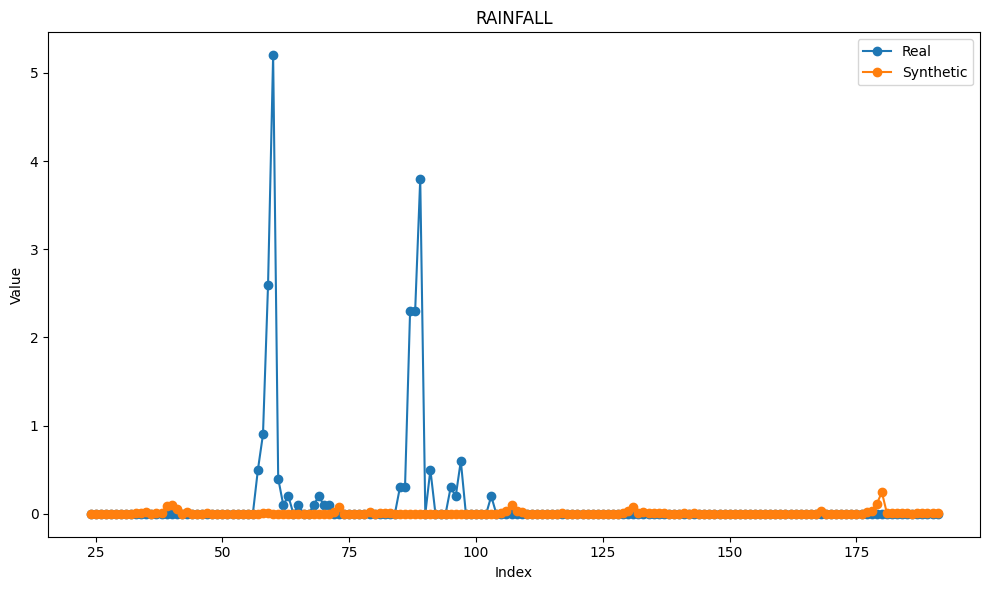

Temperature
       Real  Synthetic
0      20.8  17.312386
1      20.6  16.995079
2      20.6  16.397554
3      20.3  15.490326
4      20.2  15.314319
...     ...        ...
87595   NaN  26.271725
87596   NaN  25.077198
87597   NaN  24.852123
87598   NaN  22.603336
87599   NaN  21.607647

[87600 rows x 2 columns]


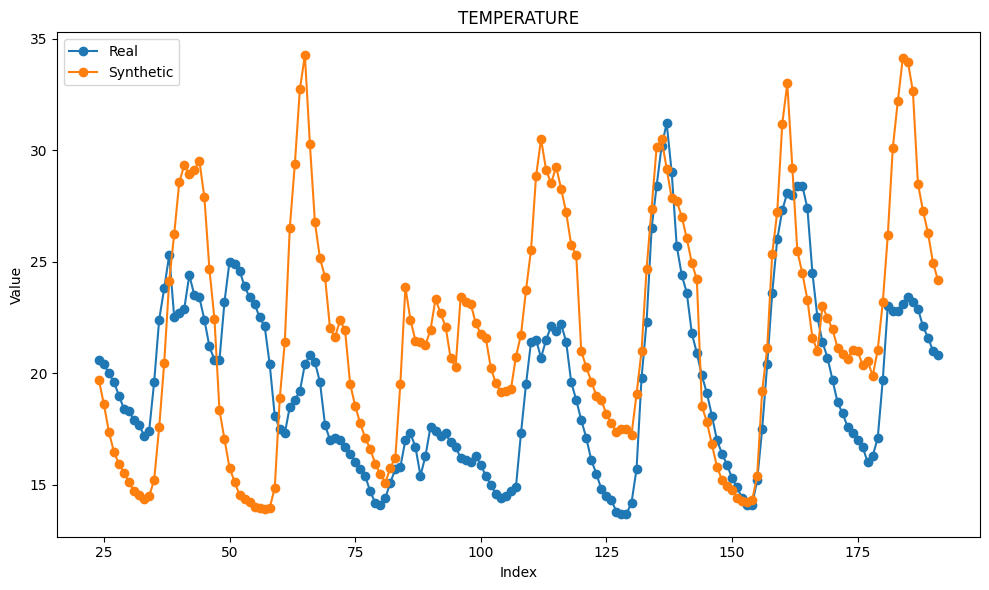

WindDirection
       Real  Synthetic
0      86.0      268.0
1      90.0      256.0
2      80.0      244.0
3      78.0      250.0
4      79.0      235.0
...     ...        ...
87595   NaN      112.0
87596   NaN      118.0
87597   NaN      109.0
87598   NaN      106.0
87599   NaN       96.0

[87600 rows x 2 columns]


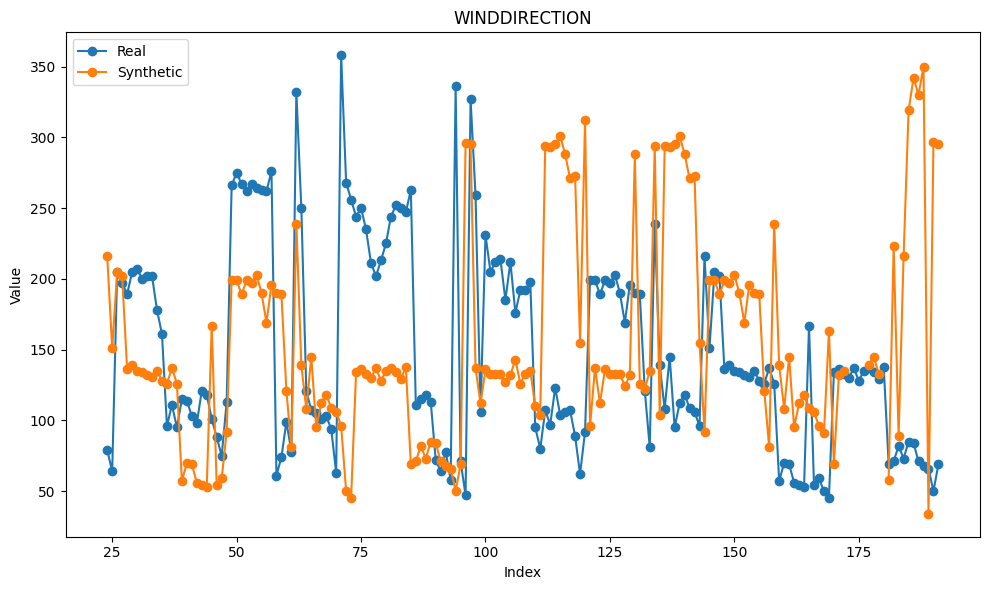

NO2
        Real  Synthetic
0      14.33  20.186134
1       9.33  21.902908
2       6.33  21.114342
3       6.33  22.622635
4       9.00  25.942627
...      ...        ...
87595    NaN  19.361753
87596    NaN  24.417564
87597    NaN  41.728771
87598    NaN  43.350182
87599    NaN  51.144775

[87600 rows x 2 columns]


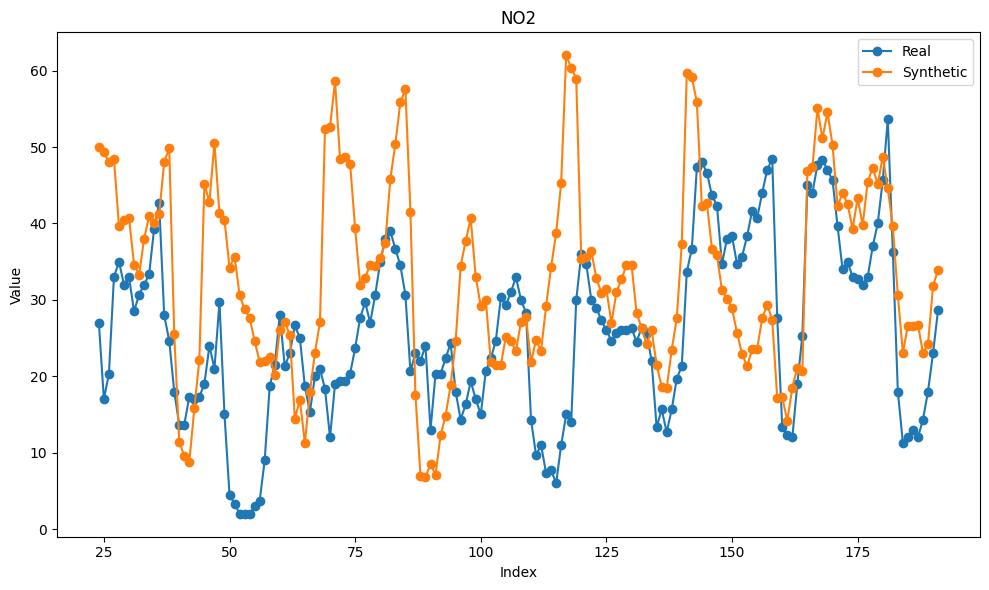

Humidity
       Real  Synthetic
0      66.0       70.0
1      66.0       69.0
2      65.0       69.0
3      68.0       73.0
4      68.0       74.0
...     ...        ...
87595   NaN       48.0
87596   NaN       56.0
87597   NaN       56.0
87598   NaN       66.0
87599   NaN       69.0

[87600 rows x 2 columns]


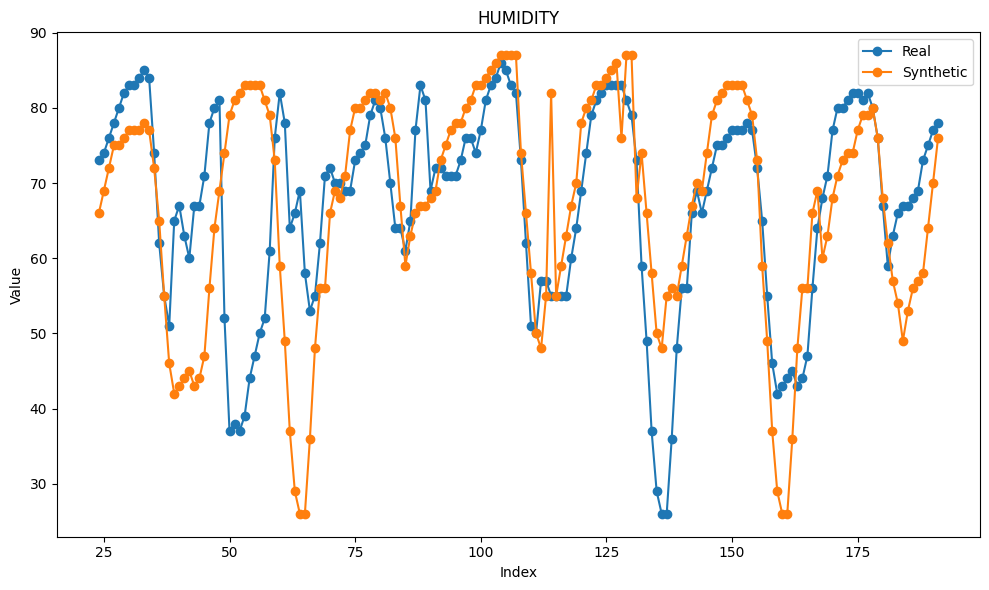

NOX
        Real  Synthetic
0      16.33  27.321321
1      11.00  25.011913
2       8.00  24.405561
3       7.00  24.103699
4      10.33  27.528259
...      ...        ...
87595    NaN  24.155636
87596    NaN  31.680874
87597    NaN  49.218262
87598    NaN  49.366844
87599    NaN  60.383156

[87600 rows x 2 columns]


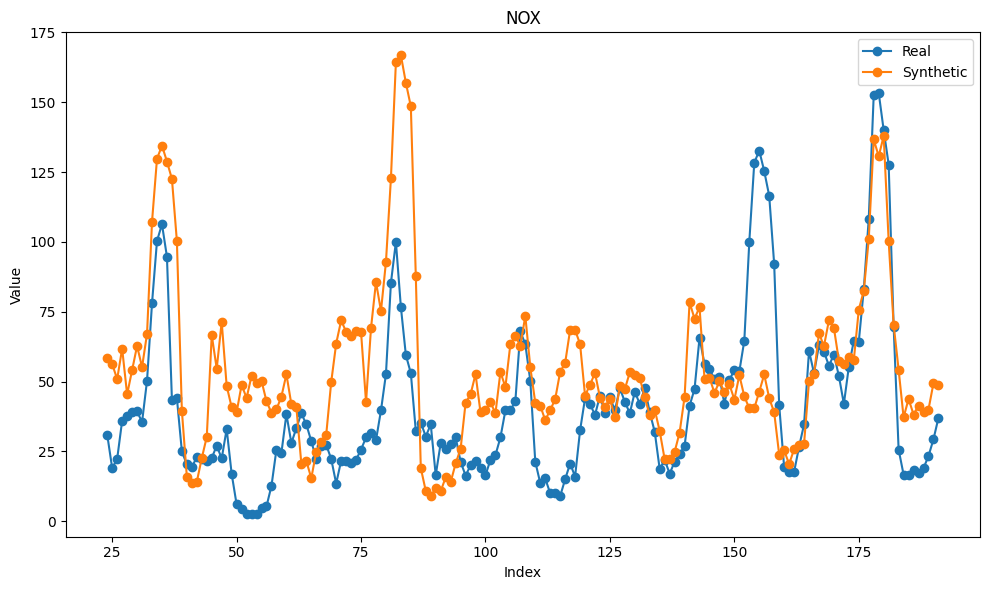

Toluene
           Real  Synthetic
0      0.630000   0.495564
1      0.690000   0.487169
2      0.750000   0.592314
3      0.766667   0.664322
4      0.783333   0.630268
...         ...        ...
87595       NaN   0.811436
87596       NaN   0.717845
87597       NaN   0.854720
87598       NaN   1.274947
87599       NaN   1.237458

[87600 rows x 2 columns]


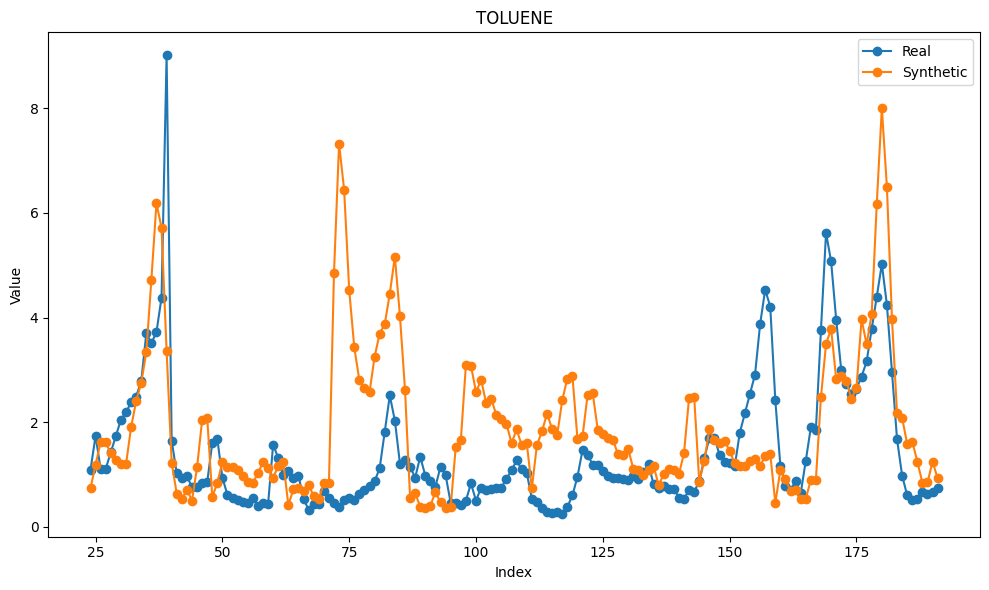

CO
       Real  Synthetic
0      0.27   0.226354
1      0.26   0.212984
2      0.23   0.223965
3      0.23   0.218695
4      0.24   0.228984
...     ...        ...
87595   NaN   0.252510
87596   NaN   0.267617
87597   NaN   0.283432
87598   NaN   0.345316
87599   NaN   0.379135

[87600 rows x 2 columns]


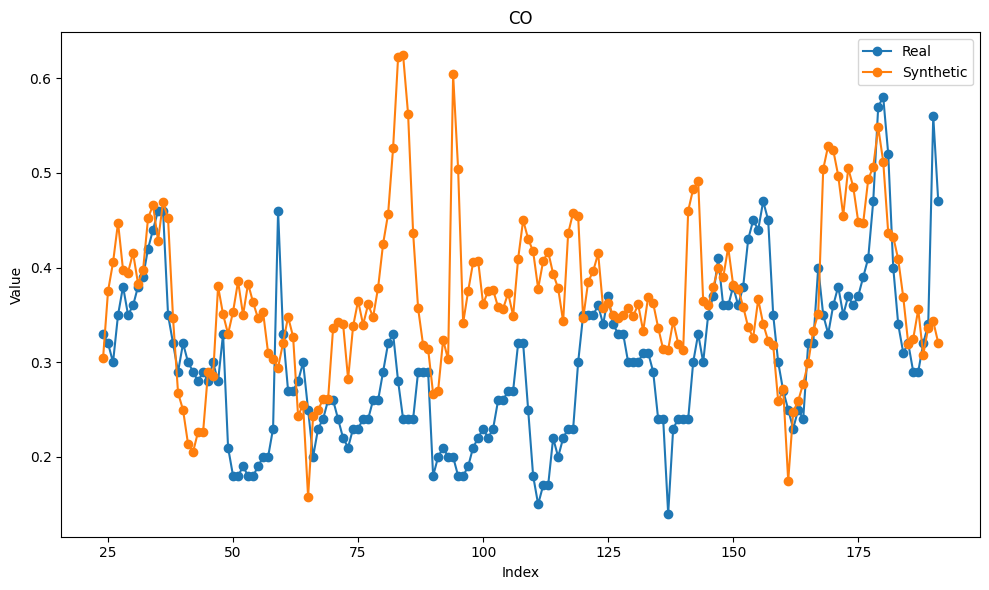

O3
       Real  Synthetic
0      63.0  15.577124
1      67.0  36.531937
2      65.5  43.287956
3      59.0  37.159054
4      49.5  20.185030
...     ...        ...
87595   NaN  78.316849
87596   NaN  70.827904
87597   NaN  55.889881
87598   NaN  36.484814
87599   NaN  19.892998

[87600 rows x 2 columns]


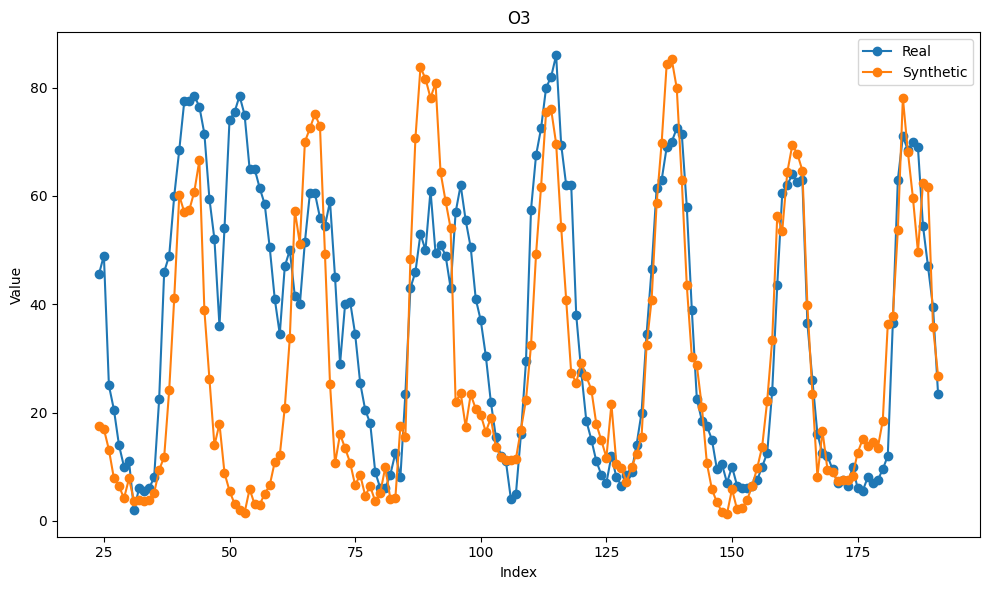

SO2
       Real  Synthetic
0      5.33   4.953796
1      5.33   4.979818
2      5.33   5.899232
3      5.33   5.672108
4      5.33   6.365295
...     ...        ...
87595   NaN   9.030376
87596   NaN   8.295846
87597   NaN   8.238689
87598   NaN   7.533587
87599   NaN   6.661254

[87600 rows x 2 columns]


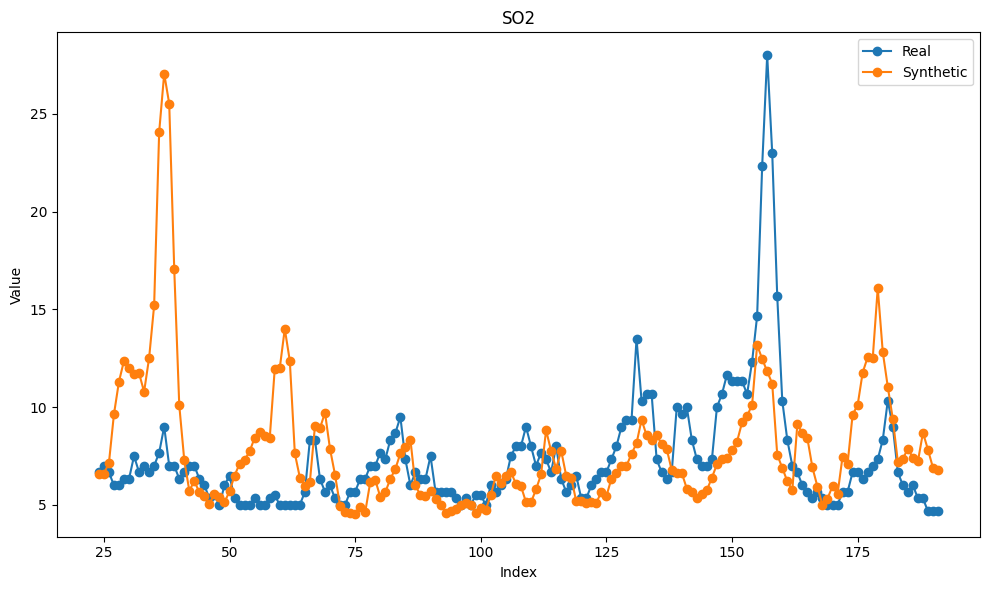

Ethylbenzene
       Real  Synthetic
0       0.0   0.014027
1       0.0   0.028921
2       0.0   0.024309
3       0.0   0.021411
4       0.0   0.017254
...     ...        ...
87595   NaN   0.055983
87596   NaN   0.032539
87597   NaN   0.040357
87598   NaN   0.087335
87599   NaN   0.092618

[87600 rows x 2 columns]


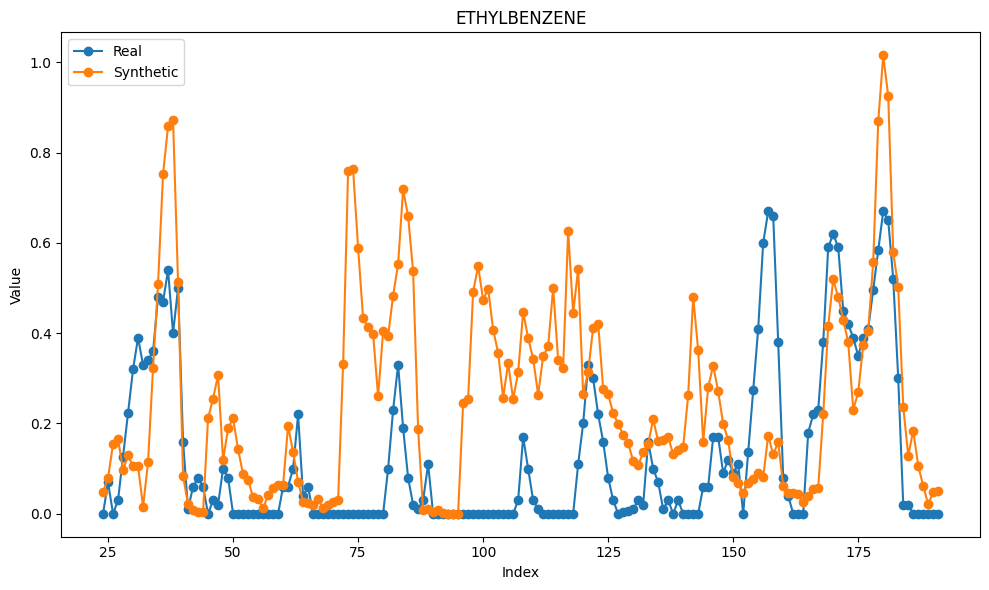

Benzene
       Real  Synthetic
0      0.03   0.006876
1      0.01   0.011572
2      0.00   0.013932
3      0.00   0.028414
4      0.00   0.011740
...     ...        ...
87595   NaN   0.122425
87596   NaN   0.035758
87597   NaN   0.018980
87598   NaN   0.096853
87599   NaN   0.196378

[87600 rows x 2 columns]


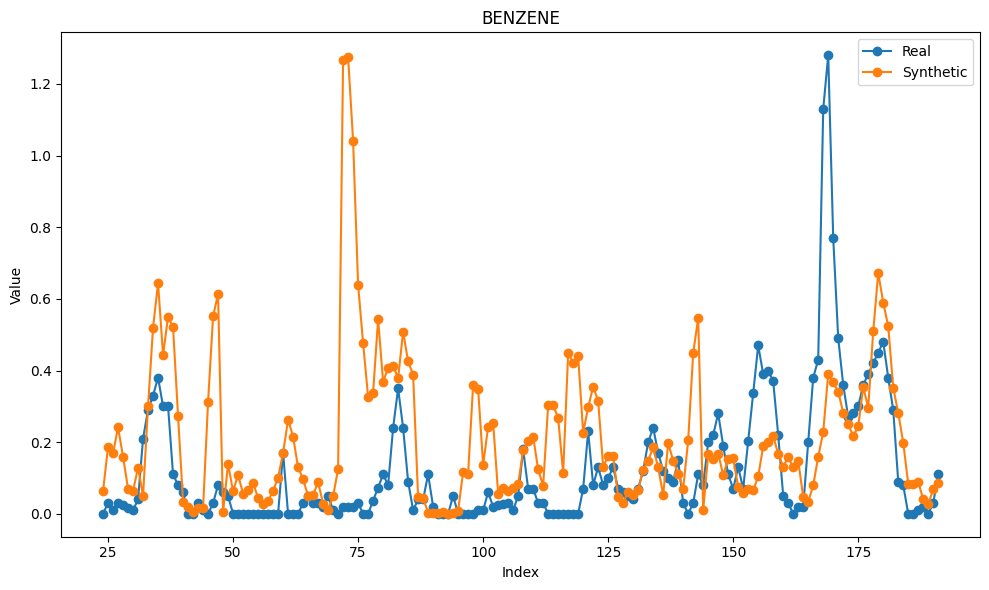

PM10
        Real  Synthetic
0      11.00  14.931691
1       9.00  13.107900
2       7.67   9.729327
3       7.33  10.924406
4       9.00   9.747330
...      ...        ...
87595    NaN  14.827778
87596    NaN  14.641642
87597    NaN  15.769534
87598    NaN  14.124075
87599    NaN  14.325504

[87600 rows x 2 columns]


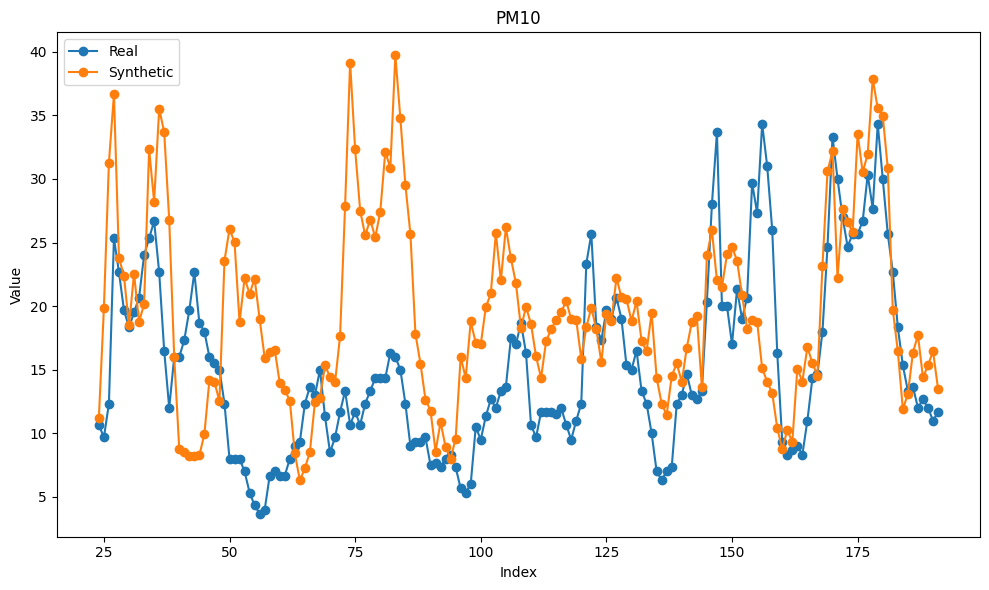

PM2.5
       Real  Synthetic
0      5.67   8.273784
1      4.67   5.730018
2      4.00   5.561239
3      3.67   5.204199
4      5.00   4.355281
...     ...        ...
87595   NaN   9.177585
87596   NaN   8.818841
87597   NaN   9.512127
87598   NaN   8.890824
87599   NaN   9.506230

[87600 rows x 2 columns]


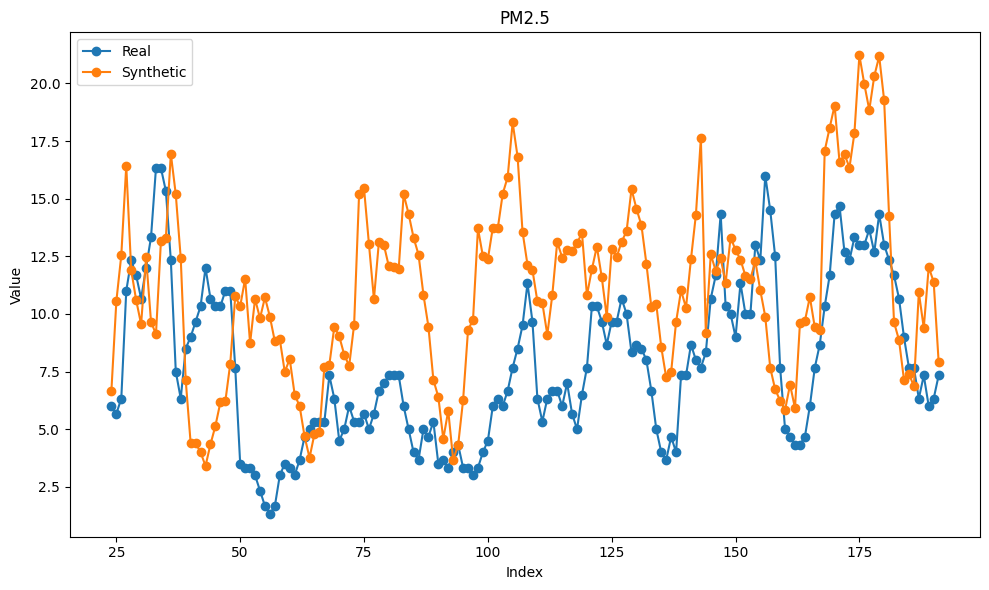

NO
       Real  Synthetic
0      1.33   1.904210
1      0.67   1.217058
2      1.00   1.533151
3      0.33   1.153015
4      1.00   1.377067
...     ...        ...
87595   NaN   3.038253
87596   NaN   4.096449
87597   NaN   6.744926
87598   NaN   6.650972
87599   NaN   9.563689

[87600 rows x 2 columns]


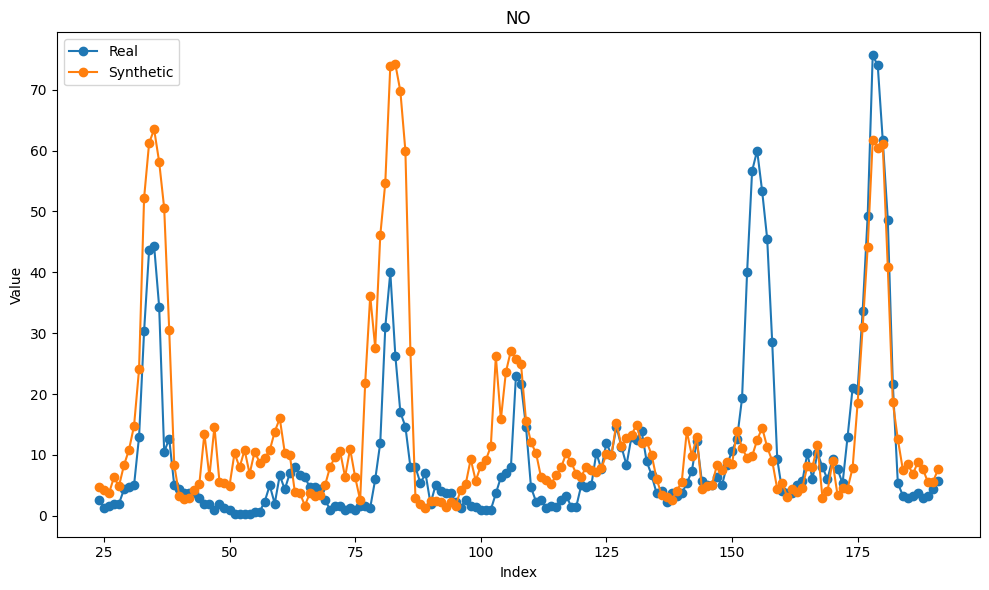

WindSpeed
       Real  Synthetic
0      2.02   0.137873
1      1.99   0.759093
2      1.38   1.858117
3      1.02   0.767499
4      0.18   0.630179
...     ...        ...
87595   NaN   4.735208
87596   NaN   3.042271
87597   NaN   2.112725
87598   NaN   0.778070
87599   NaN   0.257737

[87600 rows x 2 columns]


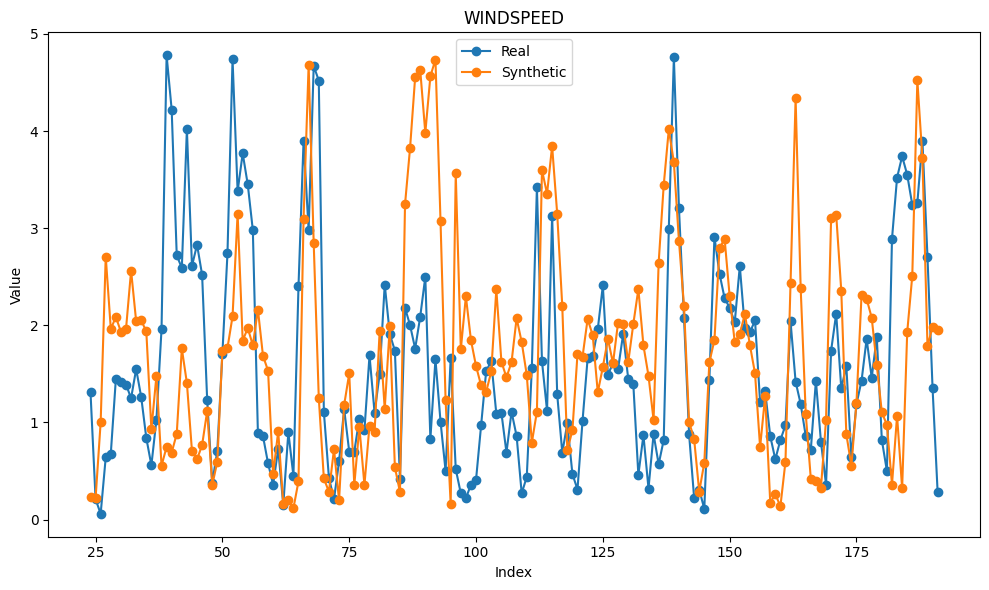

Orthoxylene
           Real  Synthetic
0      0.220000   0.189331
1      0.210000   0.171803
2      0.290000   0.305531
3      0.273333   0.415062
4      0.256667   0.438901
...         ...        ...
87595       NaN   0.481047
87596       NaN   0.414676
87597       NaN   0.560221
87598       NaN   0.730263
87599       NaN   0.705758

[87600 rows x 2 columns]


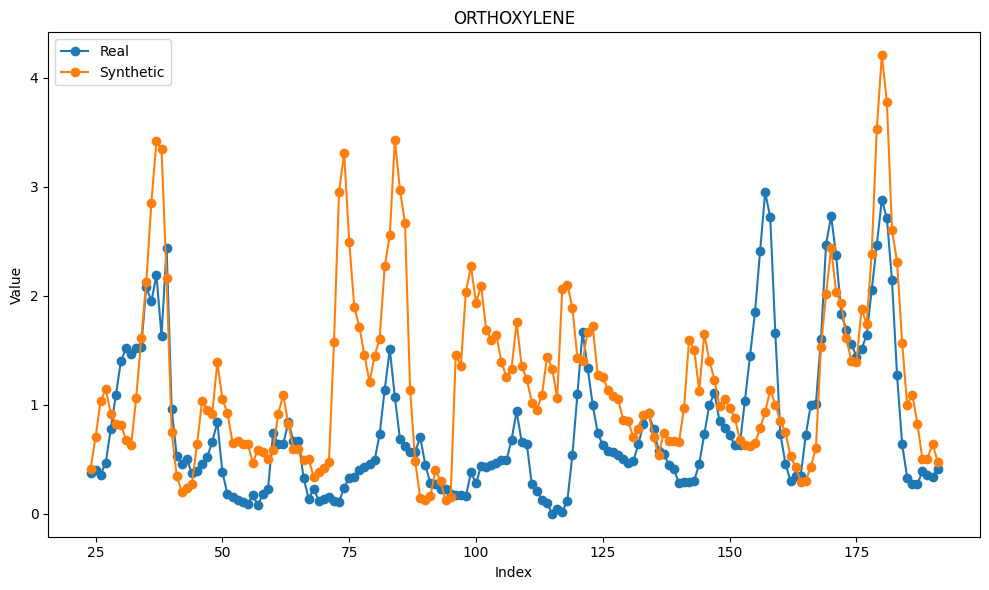

In [9]:
real_dataset = datasets['Bilbao'].copy().reset_index(drop=True)
synth_dataset = datasets['Bilbao Synth'].copy().reset_index(drop=True)

real_dataset = real_dataset.rename(
    columns={
        'SO2': 'SO2',
        'Ortoxileno': 'Orthoxylene',
        'CO': 'CO',
        'O3': 'O3',
        'SpeedWind': 'WindSpeed',
        'Etilbenceno': 'Ethylbenzene',
        'NO': 'NO',
        'NO2': 'NO2',
        'Benceno': 'Benzene',
        'Precip': 'Rainfall',
        'DirecWind': 'WindDirection',
        'Tolueno': 'Toluene',
        'PM10': 'PM10',
        'Temp': 'Temperature',
        'NOX': 'NOX',
        'PM2.5': 'PM2.5',
        'Humid': 'Humidity',
        'real': 'Real',
        'synth': 'Synthetic',
        'diff': 'Difference'
    })
synth_dataset = synth_dataset.rename(
    columns={
        'SO2': 'SO2',
        'Ortoxileno': 'Orthoxylene',
        'CO': 'CO',
        'O3': 'O3',
        'SpeedWind': 'WindSpeed',
        'Etilbenceno': 'Ethylbenzene',
        'NO': 'NO',
        'NO2': 'NO2',
        'Benceno': 'Benzene',
        'Precip': 'Rainfall',
        'DirecWind': 'WindDirection',
        'Tolueno': 'Toluene',
        'PM10': 'PM10',
        'Temp': 'Temperature',
        'NOX': 'NOX',
        'PM2.5': 'PM2.5',
        'Humid': 'Humidity',
        'real': 'Real',
        'synth': 'Synthetic',
        'diff': 'Difference'
    })

start_window = 24 * 1
window_size = 24 * 7

for col in list(set(col[0] for col in bilbao_combined_described_df_cleaned.T.columns)):

    print(col)
    combined_df = pd.DataFrame({
        'Real': real_dataset[col],
        'Synthetic': synth_dataset[col]
    })
    print(combined_df)

    plt.figure(figsize=(10, 6))
    plt.plot(combined_df.index[start_window:start_window+window_size], combined_df['Real'].iloc[start_window:start_window+window_size], label='Real', marker='o')
    plt.plot(combined_df.index[start_window:start_window+window_size], combined_df['Synthetic'].iloc[start_window:start_window+window_size], label='Synthetic', marker='o')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(col.upper())
    plt.legend()
    plt.grid(False)
    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout()
    # Obtener el objeto Figure asociado al objeto Axes
    fig = plt.gcf()  # gcf() devuelve la figura actual
    # Guardar la figura
    fig.savefig(f'figures/TS_{col}.png', dpi=300, bbox_inches='tight')
    # Mostrar la figura
    plt.show()